In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from copy import deepcopy as copy
from astropy.table import Table

from lvmdrp import path, __version__ as drpver
from lvmdrp.core.constants import ARC_LAMPS, SPEC_CHANNELS
from lvmdrp.core import rss
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod, rssMethod


import matplotlib.pyplot as plt
from lvmdrp.core.spectrum1d import Spectrum1D


def subtract_continuum(in_rss, out_rss, median_box=30, thresh=1.2, niter=5, mask_delt=1):
    arc = rssMethod.loadRSS(in_rss)
    
    cont_rss = np.zeros_like(arc._data)
    for ifiber in range(arc._fibers):
        if ifiber not in arc._good_fibers:
            continue
        spec = arc.getSpec(ifiber)

        spec_s = copy(spec)
        spec_s.smoothSpec(size=median_box, method="median")

        cur_mask = 0
        for i in range(niter):
            mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) < thresh

            spec_s = Spectrum1D(data=np.interp(spec._pixels, spec._pixels[mask], spec._data[mask]))
            spec_s.smoothSpec(size=30, method="median")

            if np.abs(cur_mask - mask.sum()) <= mask_delt: break
            cur_mask = mask.sum()

        # define continuum with last iteration's mask
        mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) < thresh
        cont_rss[ifiber] = np.interp(spec._pixels, spec._pixels[mask], spec._data[mask])
    
    out_con = copy(arc)
    out_con.setData(data=cont_rss)
    new_arc = copy(arc)
    new_arc.setData(data=arc._data - cont_rss)
    
    new_arc.writeFitsData(out_rss)
    
    return new_arc, out_con


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
frames_table = md.get_metadata(tileid="*", mjd=60177)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)
frames_table = frames_table.loc[frames_table.name.str.contains("sdR")]

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: found 513 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5'
[INFO]: number of frames after filtering 513
[INFO]: total number of frames found 513


In [3]:
masters_mjd = qdrp.get_master_mjd(frames_table.mjd.min())
masters_path = os.path.join(ORIG_MASTER_DIR, str(masters_mjd))
print(masters_path)

/home/mejia/Research/lvm/lvmdata/calib/60177


[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b1.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_b1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 35 percentage masked  68.5714 %
[INFO]: 11 good lines found
[INFO]: running cross matching on all 35 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b1.fits


[INFO]: max CC = 0.39 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   0%|          | 0/319 [00:00<?, ?fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319:  32%|###1      | 101/319 [00:02<00:05, 43.40fiber/s][WARNING]: divide by zero encountered in divide (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:07<00:00, 44.59fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:08<00:00, 38.76fiber/s]


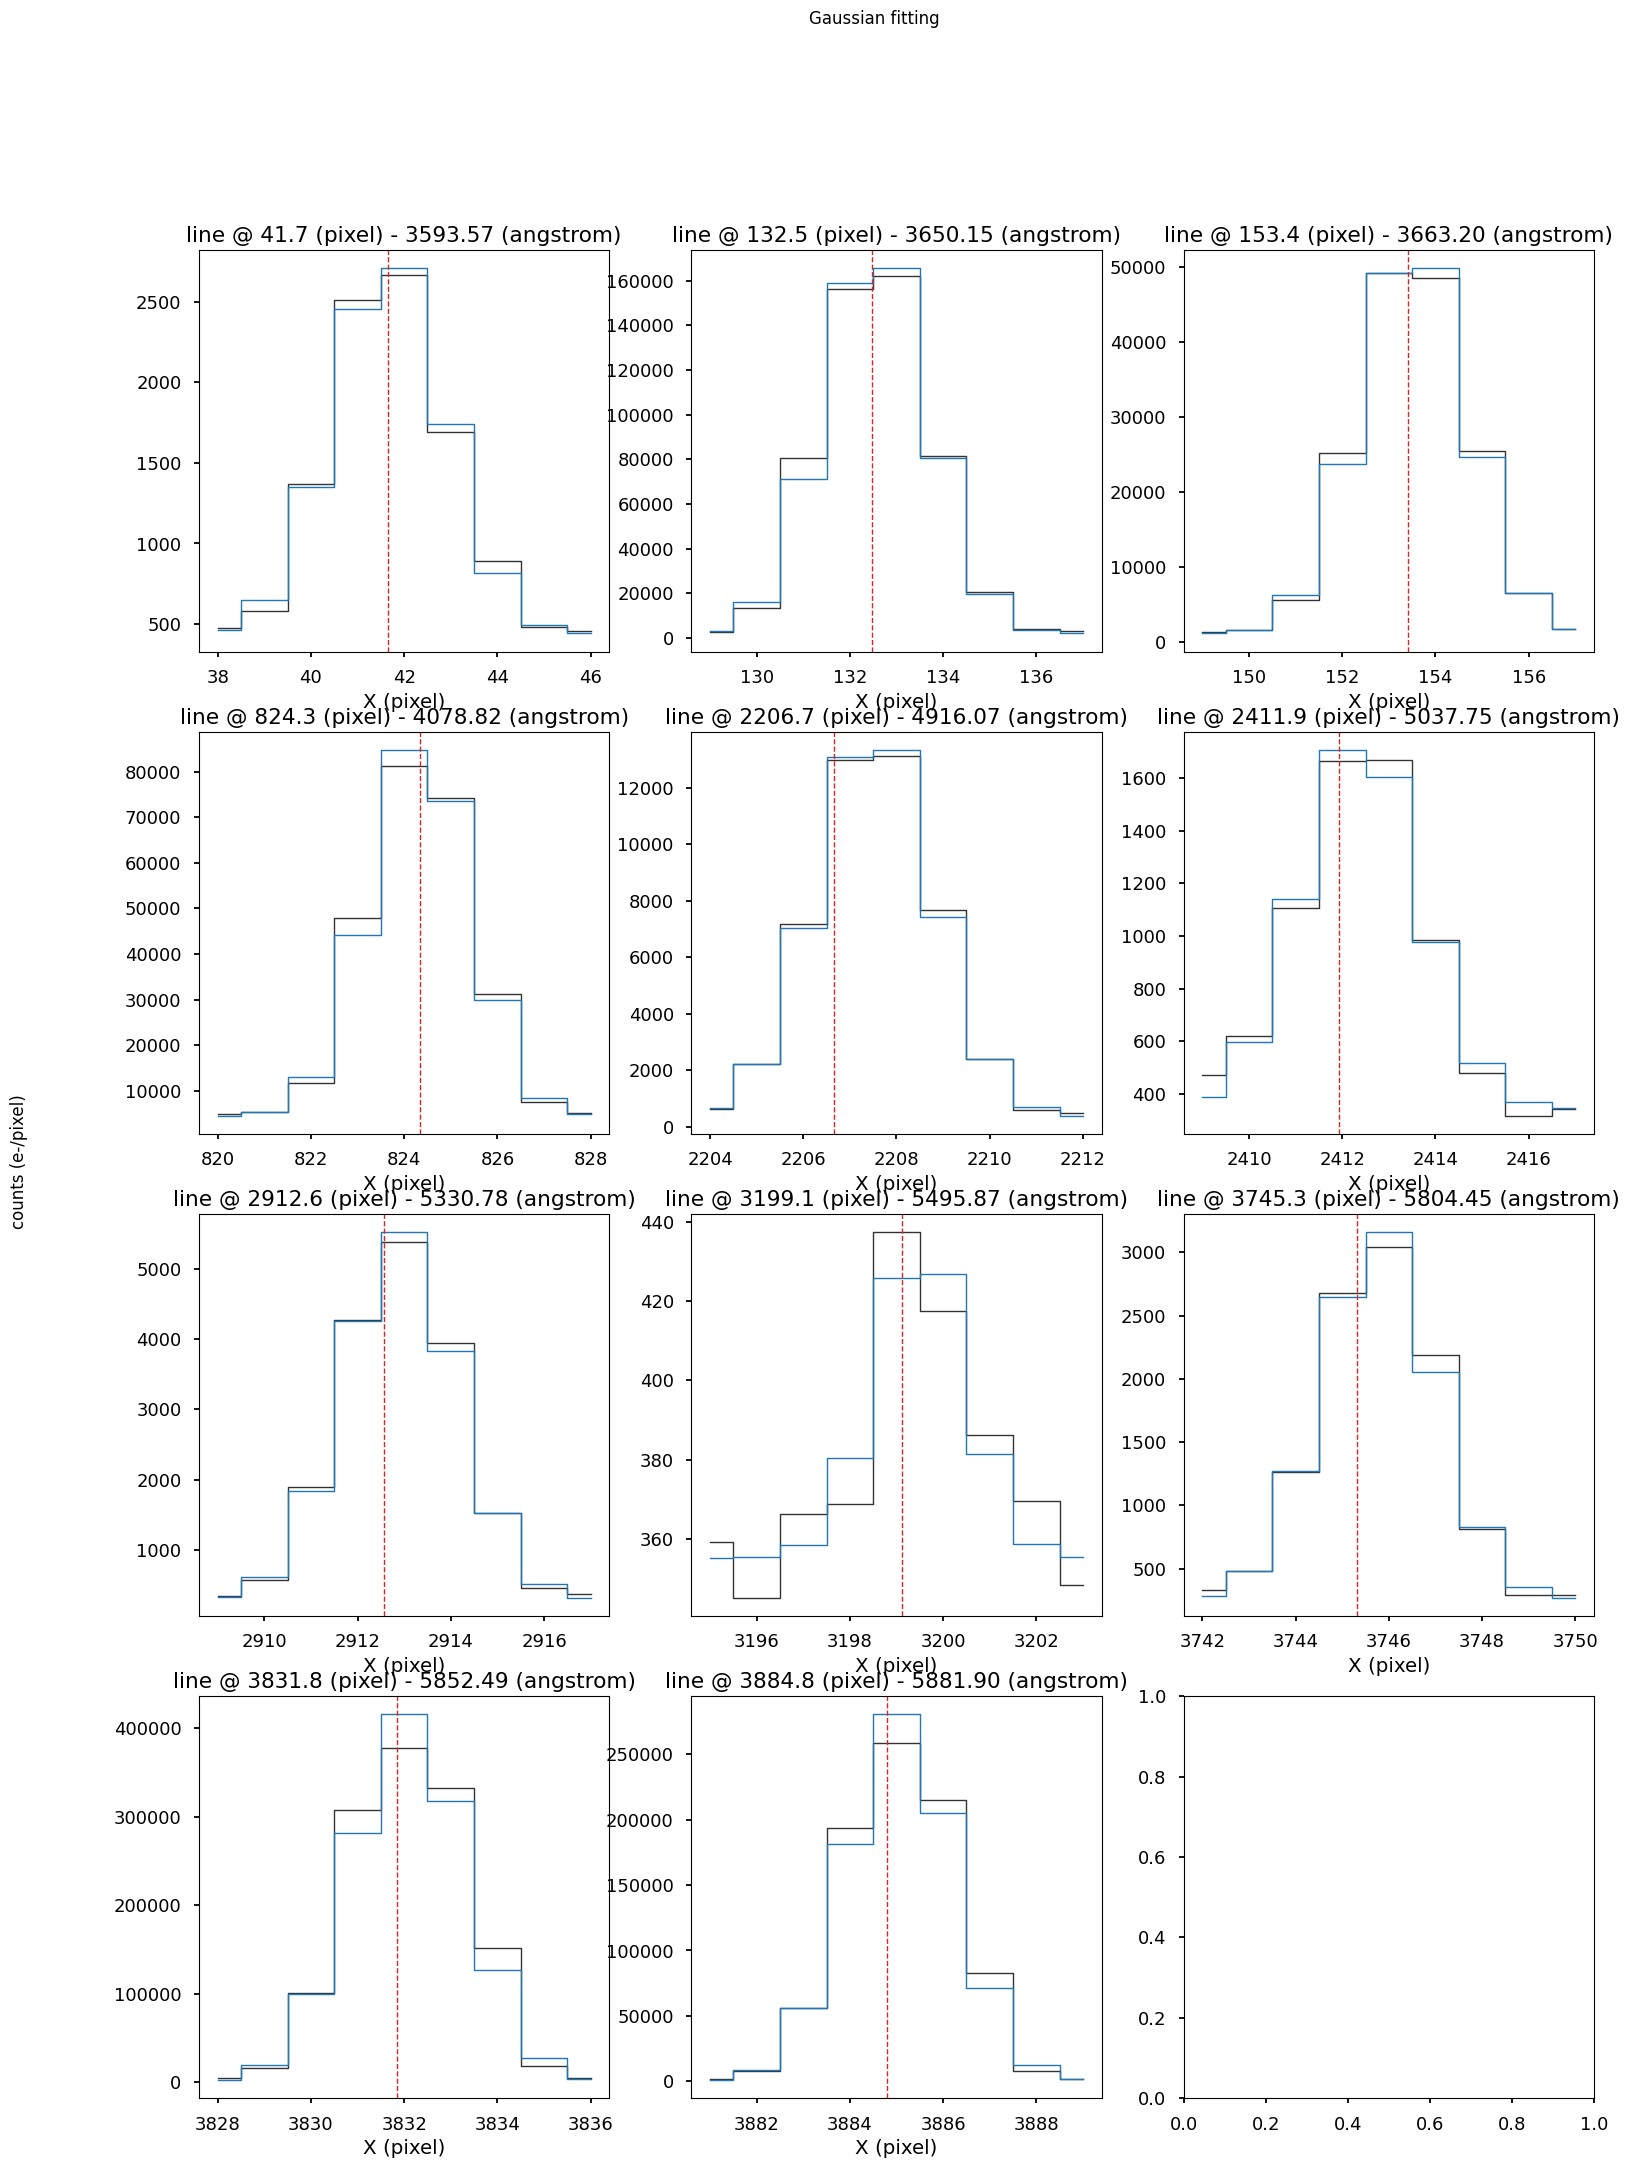

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 1 has all lines masked
[WARNING]: fiber 49 has all lines masked
[WARNING]: fiber 75 has all lines masked
[WARNING]: fiber 89 has all lines masked
[WARNING]: fiber 100 has all lines masked
[WARNING]: fiber 102 has all lines masked
[WARNING]: fiber 105 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 160 has all lines masked
[WARNING]: fiber 172 has all lines masked
[WARNING]: fiber 173 has all lines masked
[WARNING]: fiber 183 has all lines masked
[WARNING]: fiber 196 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 325 has all lines masked
[WARNING]: fiber 397 has all lines masked
[WARNING]: fiber 414 has all lines masked
[WARNING]: fiber 462 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: fiber 508 has all lines masked
[WARNING]: fib

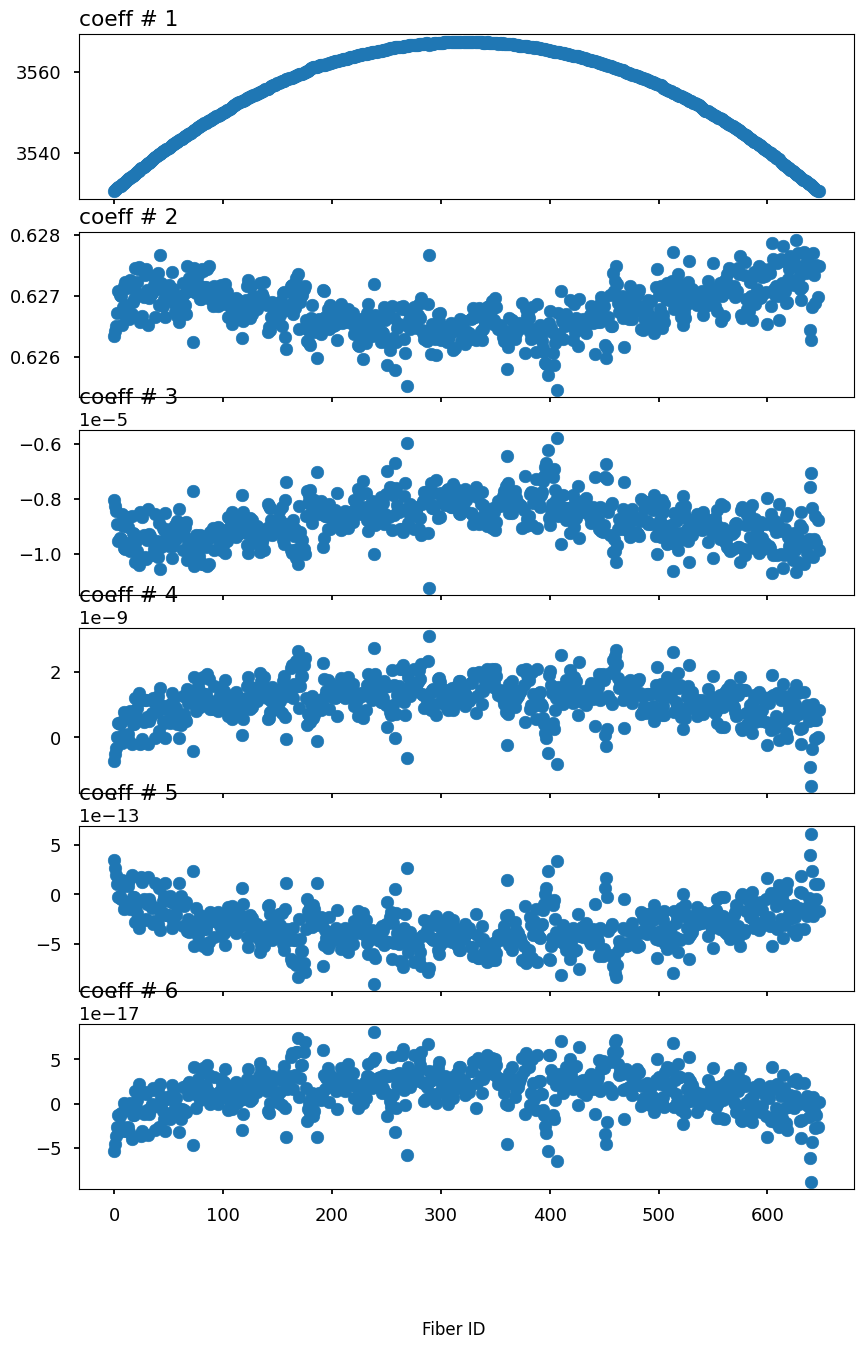

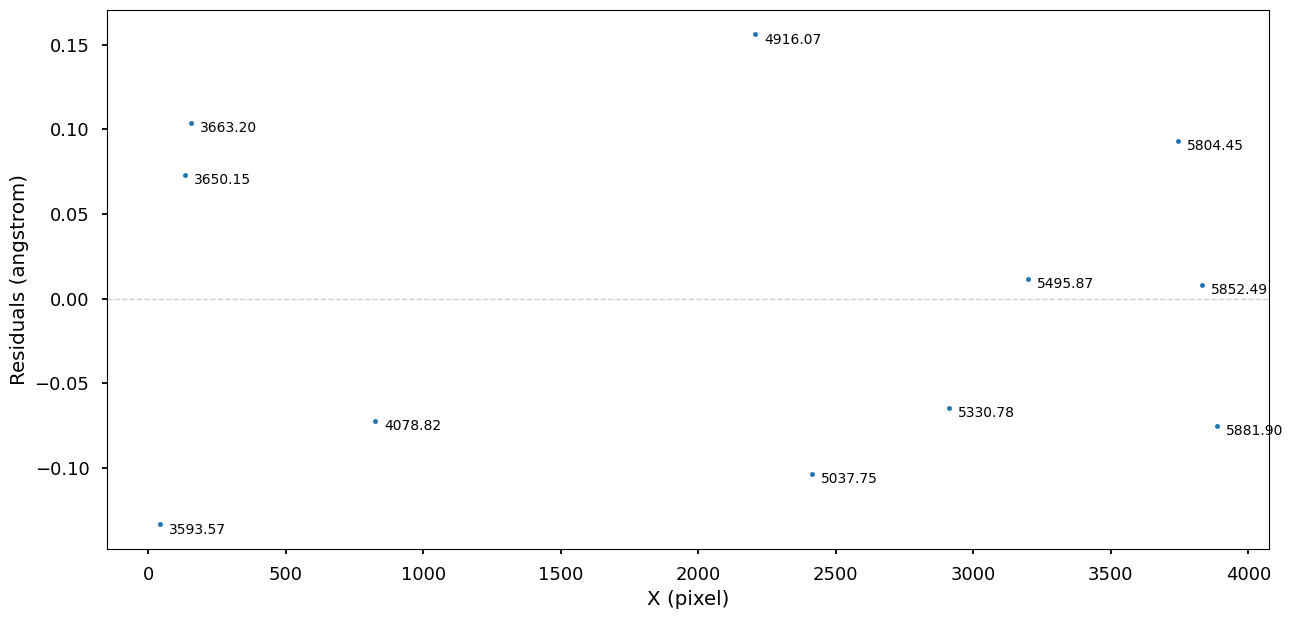

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


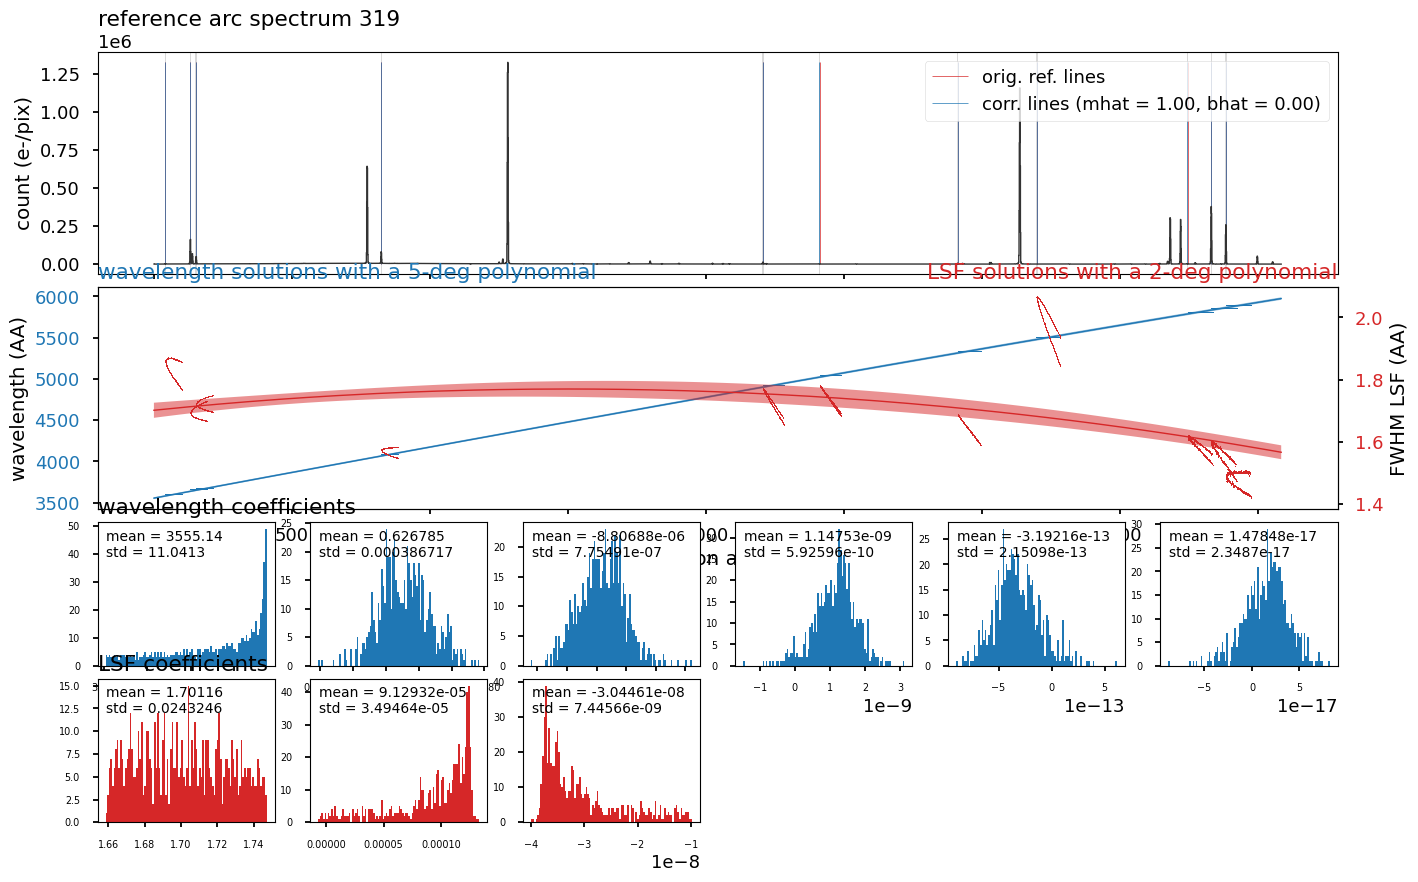

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-b1.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-b1.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b2.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_b2.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 35 percentage masked  65.7143 %
[INFO]: 12 good lines found
[INFO]: running cross matching on all 35 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b2.fits


[INFO]: max CC = 0.35 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   4%|3         | 12/319 [00:00<00:04, 67.48fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319:   6%|5         | 19/319 [00:00<00:12, 23.60fiber/s][WARNING]: divide by zero encountered in divide (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:07<00:00, 43.15fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:07<00:00, 44.41fiber/s]


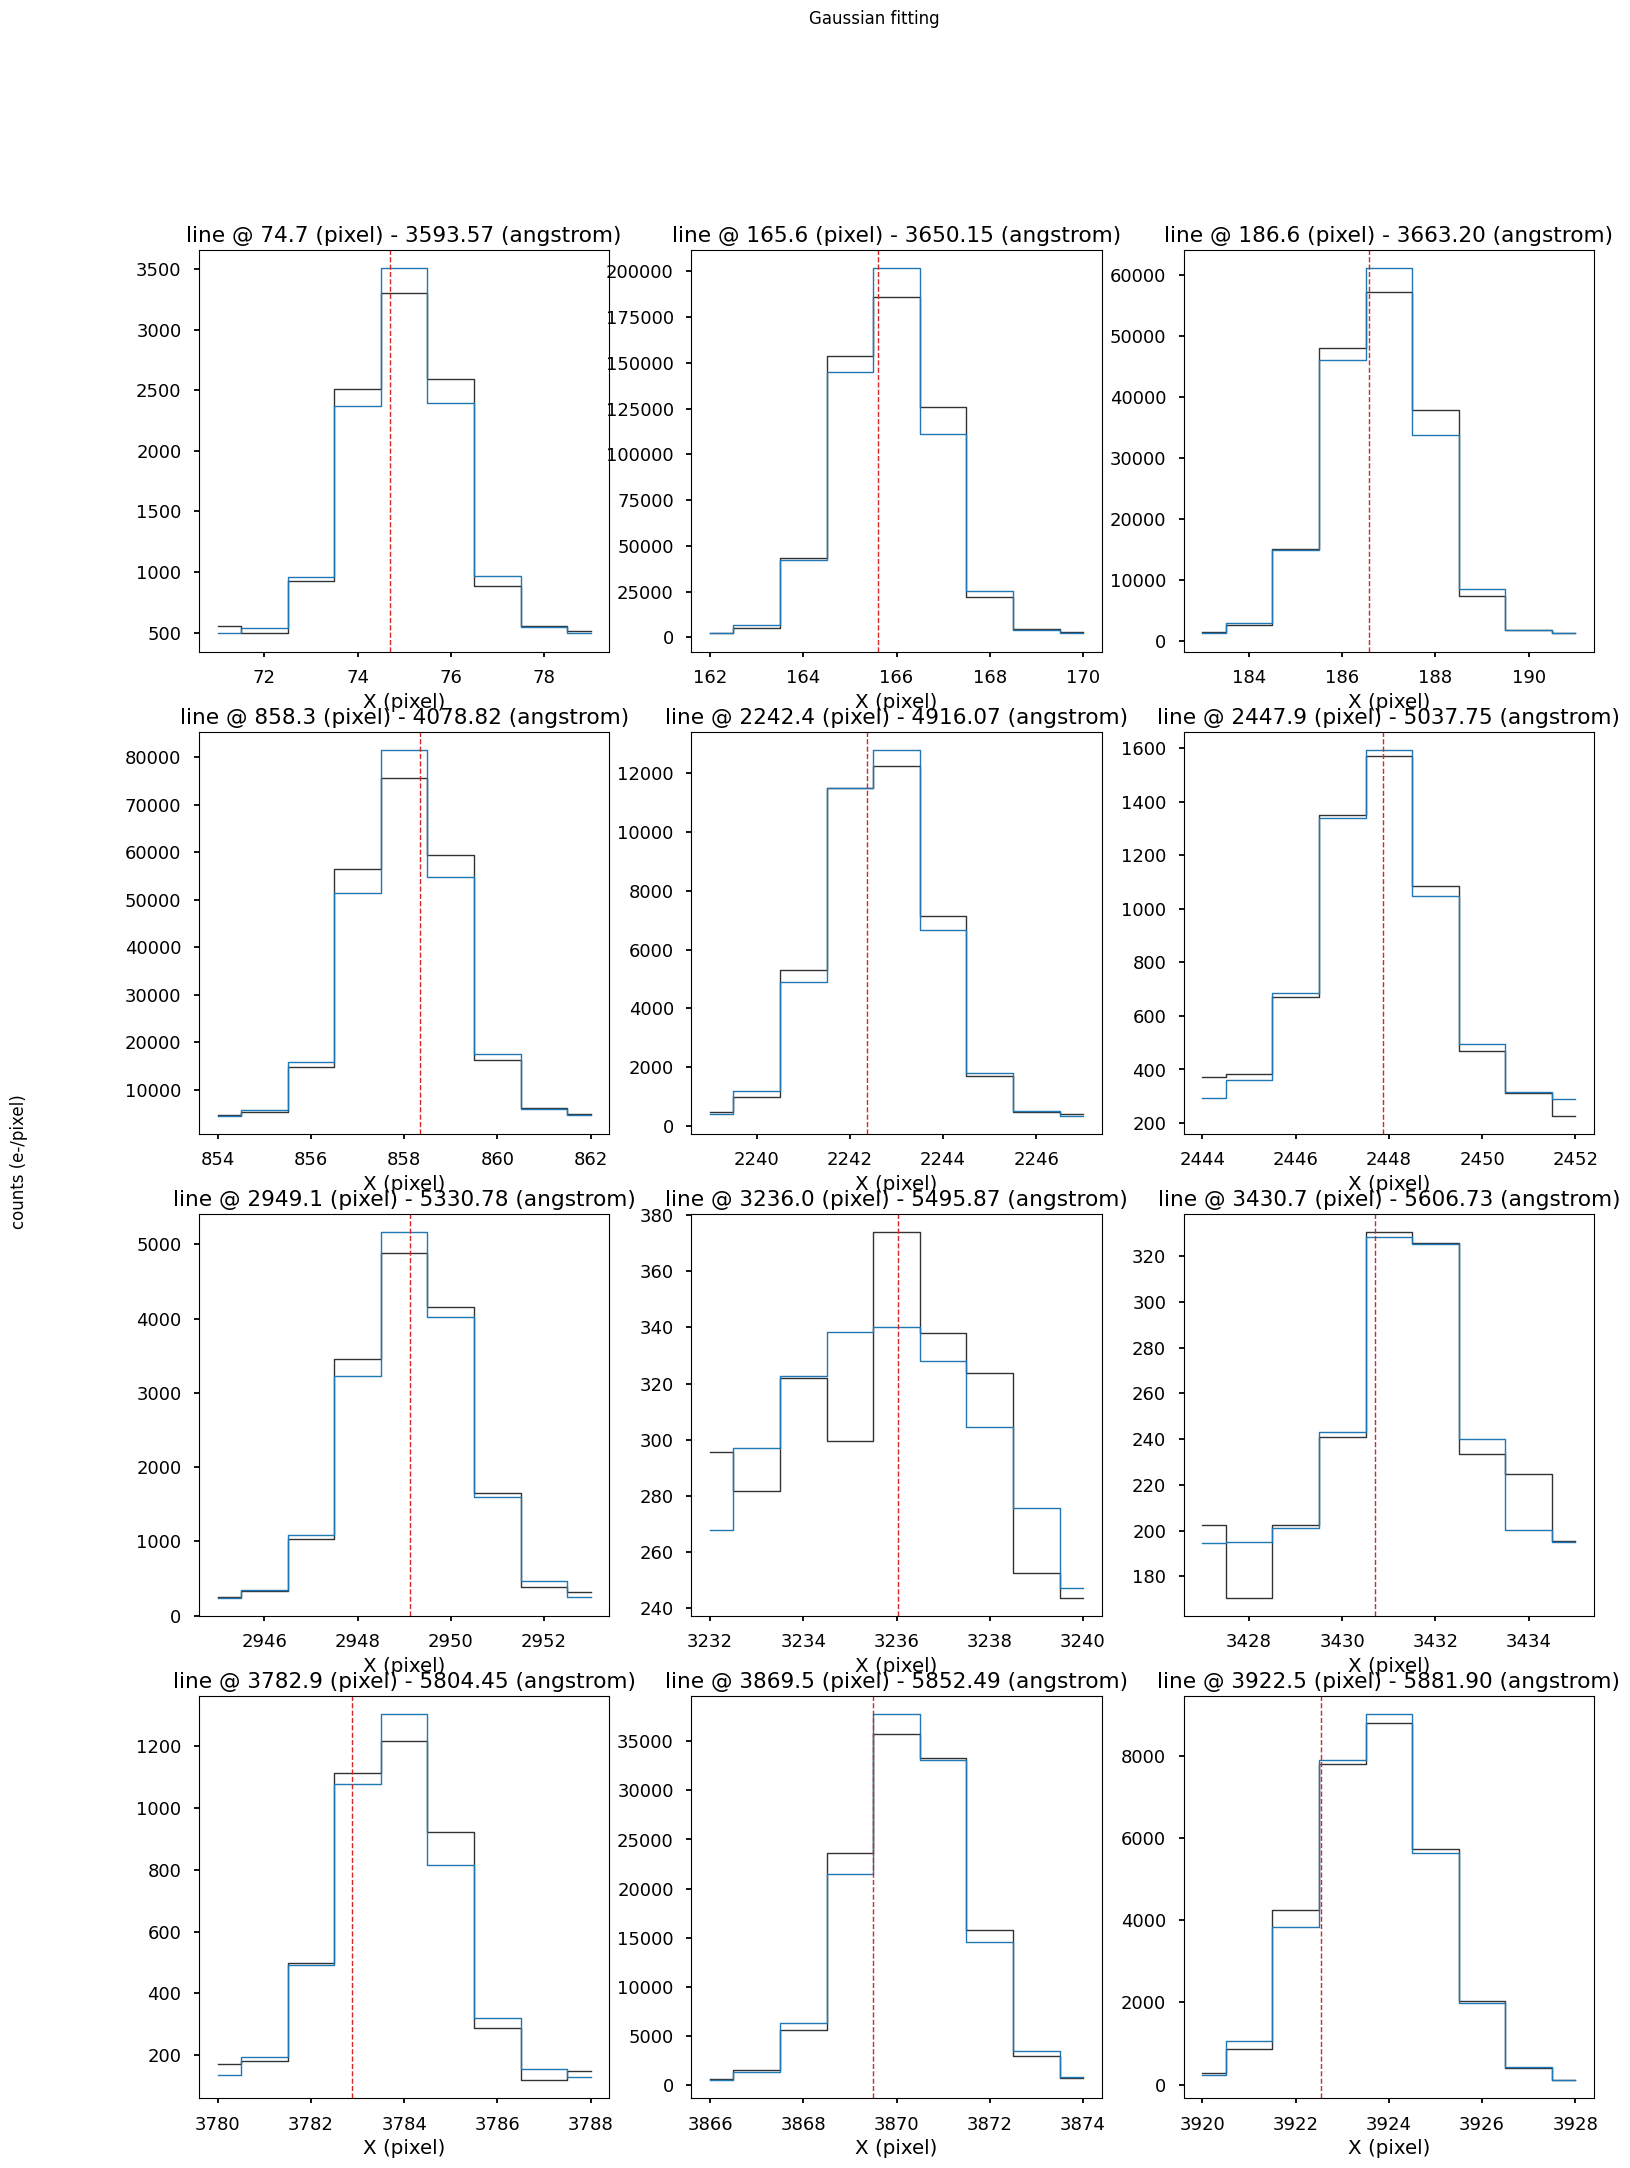

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 28 has all lines masked
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 127 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 141 has all lines masked
[WARNING]: fiber 142 has all lines masked
[WARNING]: fiber 157 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 250 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 285 has all lines masked
[WARNING]: fiber 289 has all lines masked
[WARNING]: fiber 325 has all lines masked
[WARNING]: fiber 335 has all lines masked
[WARNING]: fiber 397 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 445 has all lines masked
[WARNING]: fiber 455 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: 

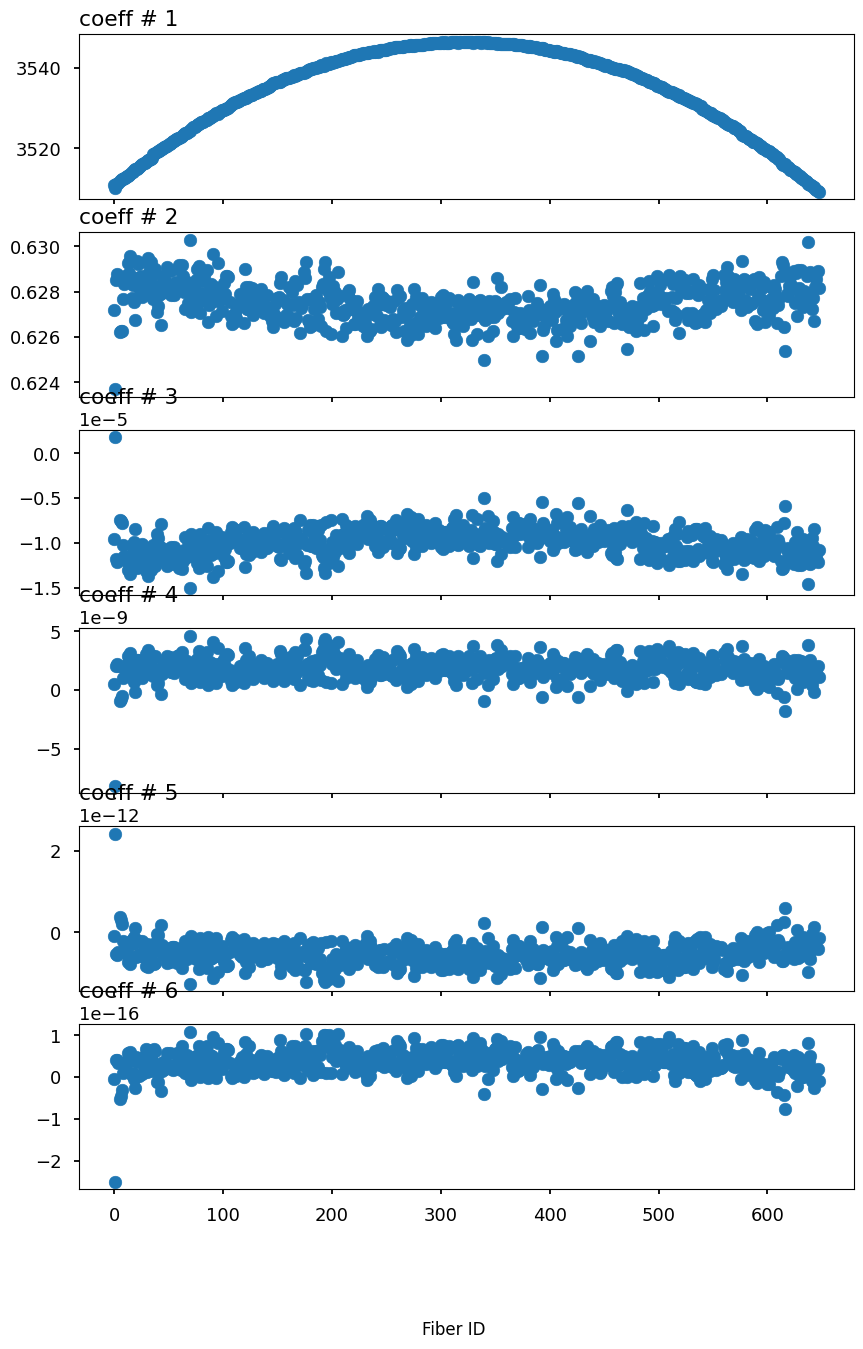

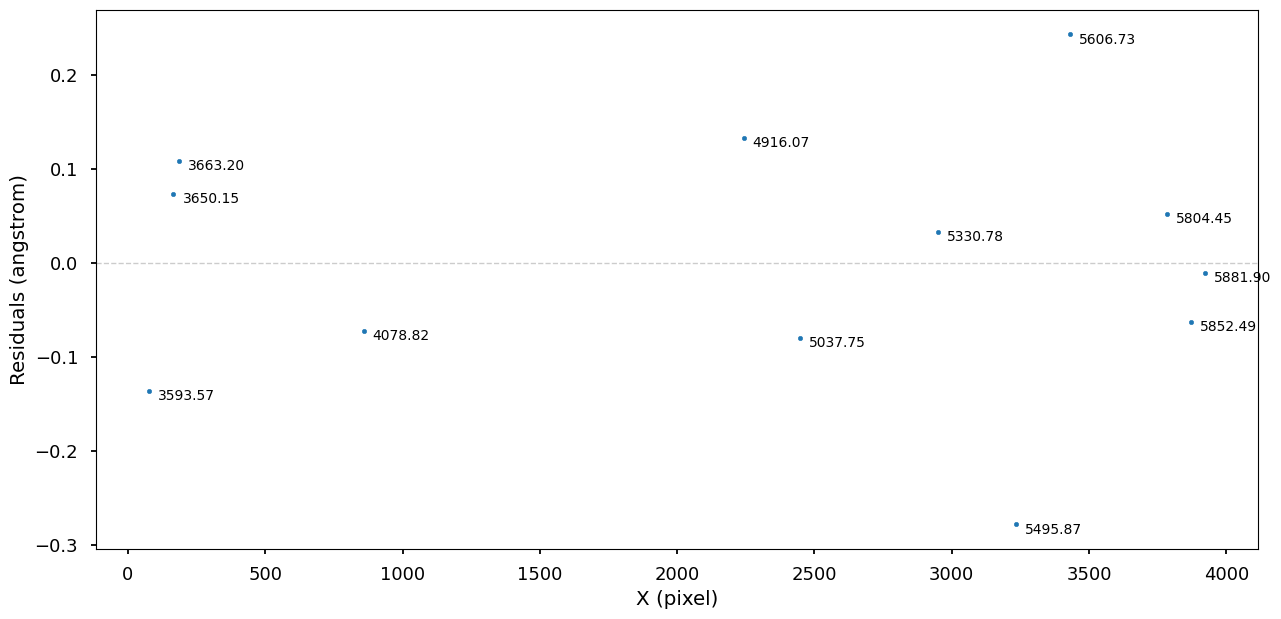

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


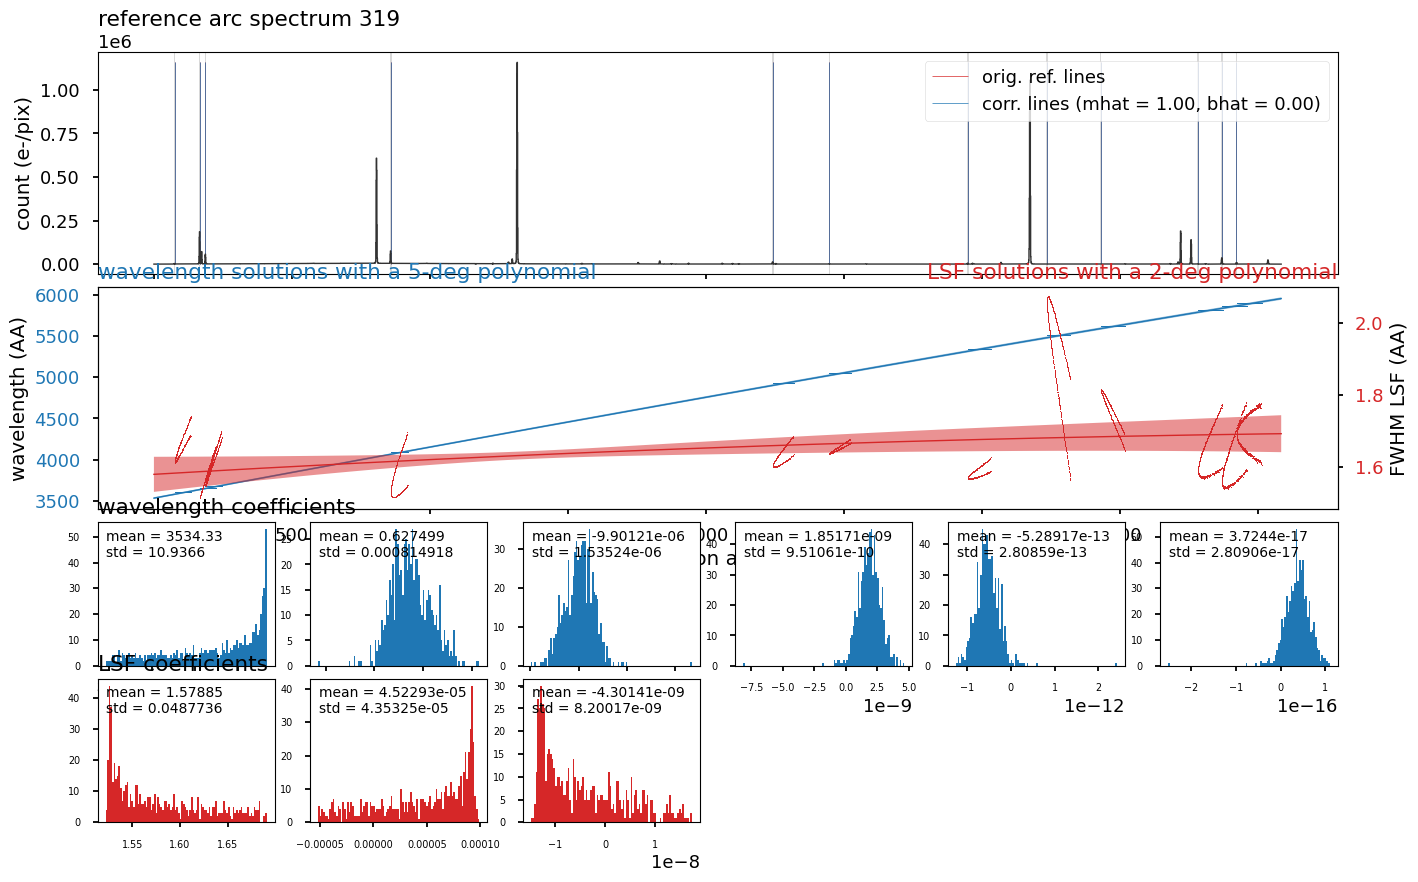

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-b2.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-b2.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b3.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_b3.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 35 percentage masked  65.7143 %
[INFO]: 12 good lines found
[INFO]: running cross matching on all 35 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b3.fits


[INFO]: max CC = 0.35 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   0%|          | 0/319 [00:00<?, ?fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319:   7%|6         | 22/319 [00:00<00:08, 35.90fiber/s][WARNING]: divide by zero encountered in divide (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:07<00:00, 42.46fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:10<00:00, 31.07fiber/s]


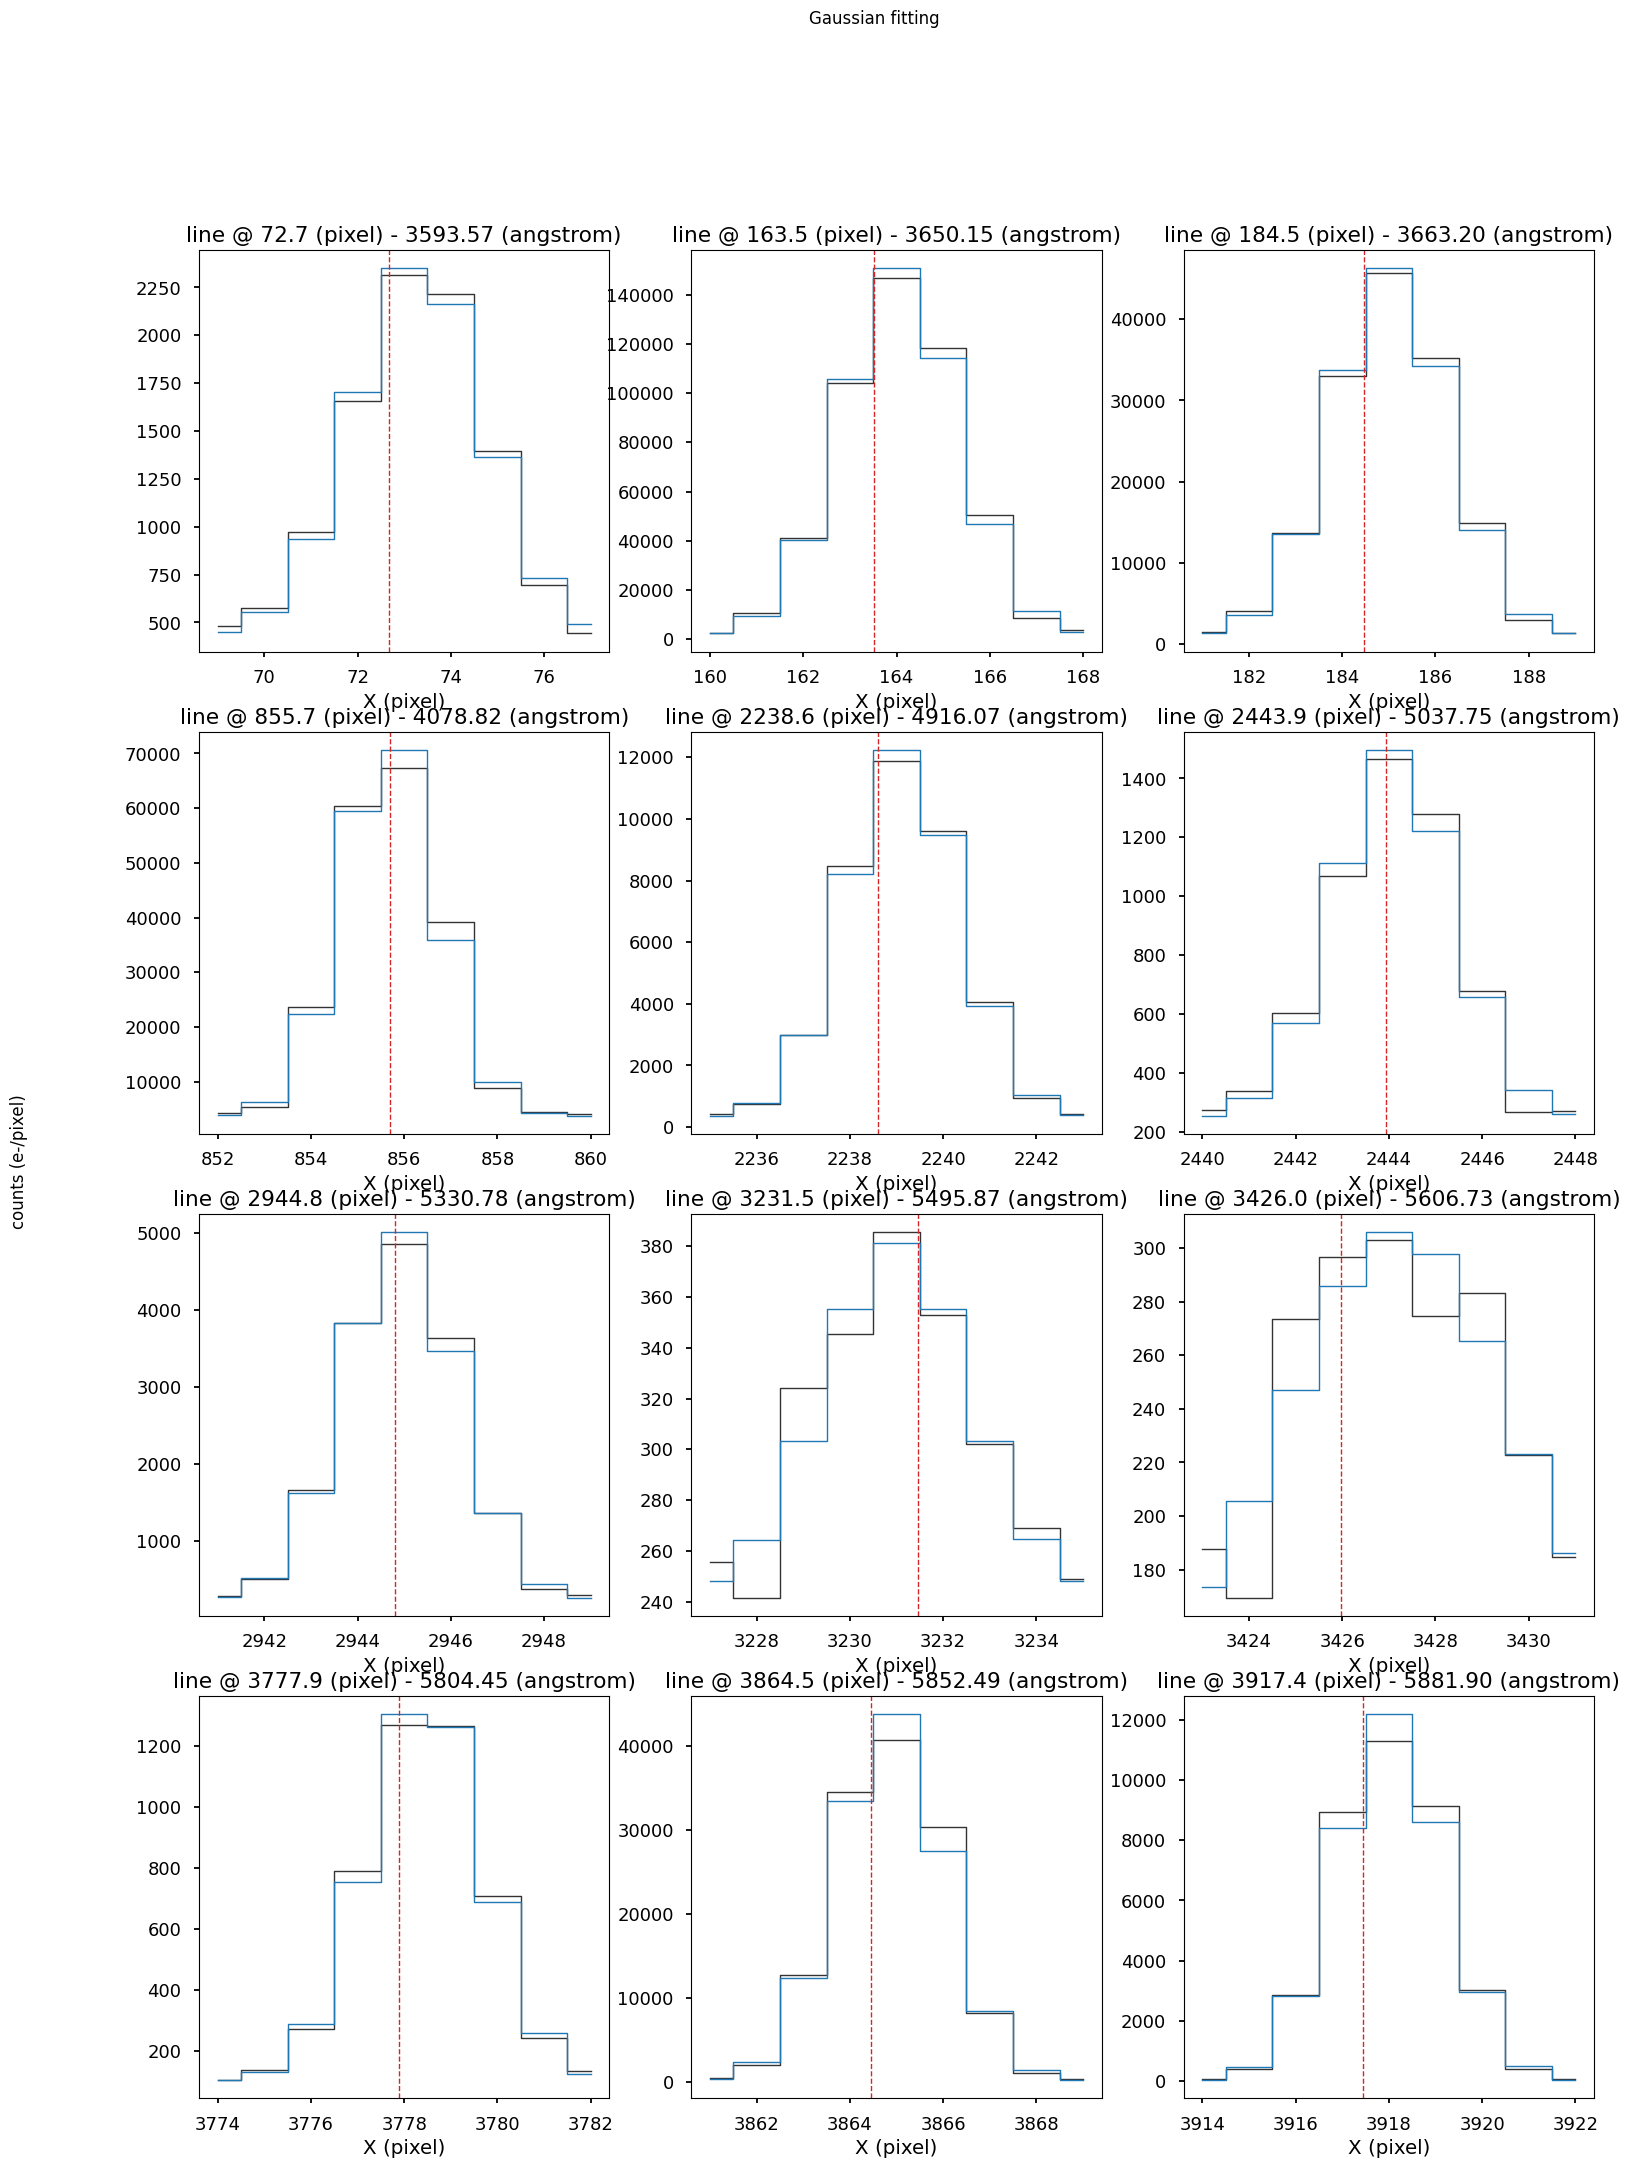

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 289 has all lines masked
[WARNING]: fiber 325 has all lines masked
[WARNING]: fiber 397 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 447 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: fiber 506 has all lines masked
[WARNING]: fiber 512 has all lines masked
[WARNING]: fiber 556 has all lines masked
[WARNING]: fiber 563 has all lines masked
[WARNING]: fiber 575 has all lines masked
[WARNING]: fiber 580 has all lines masked
[WARNING]: fiber 613 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 0.10729 AA (0.18109 pix)
[INFO]: fitting

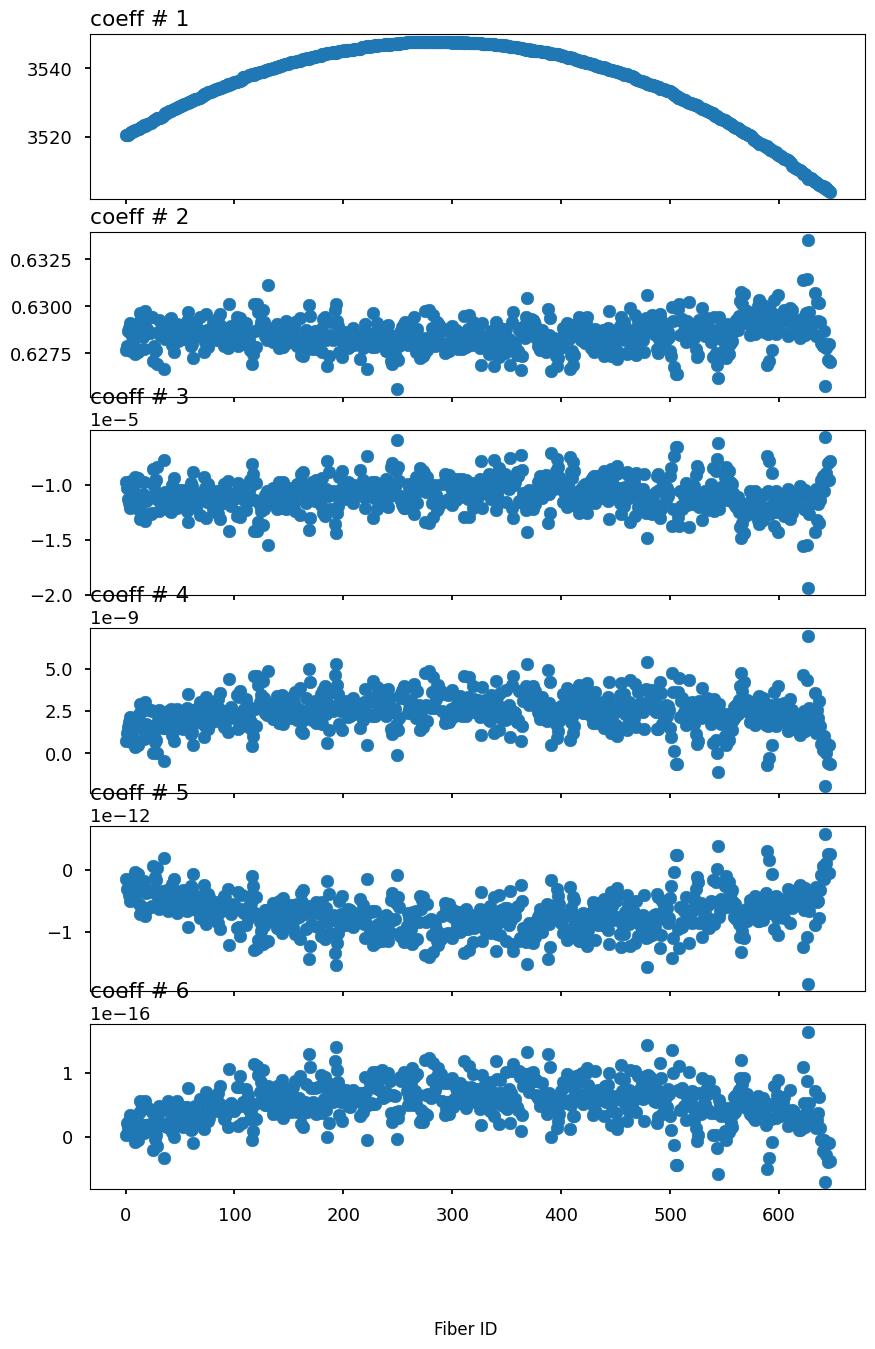

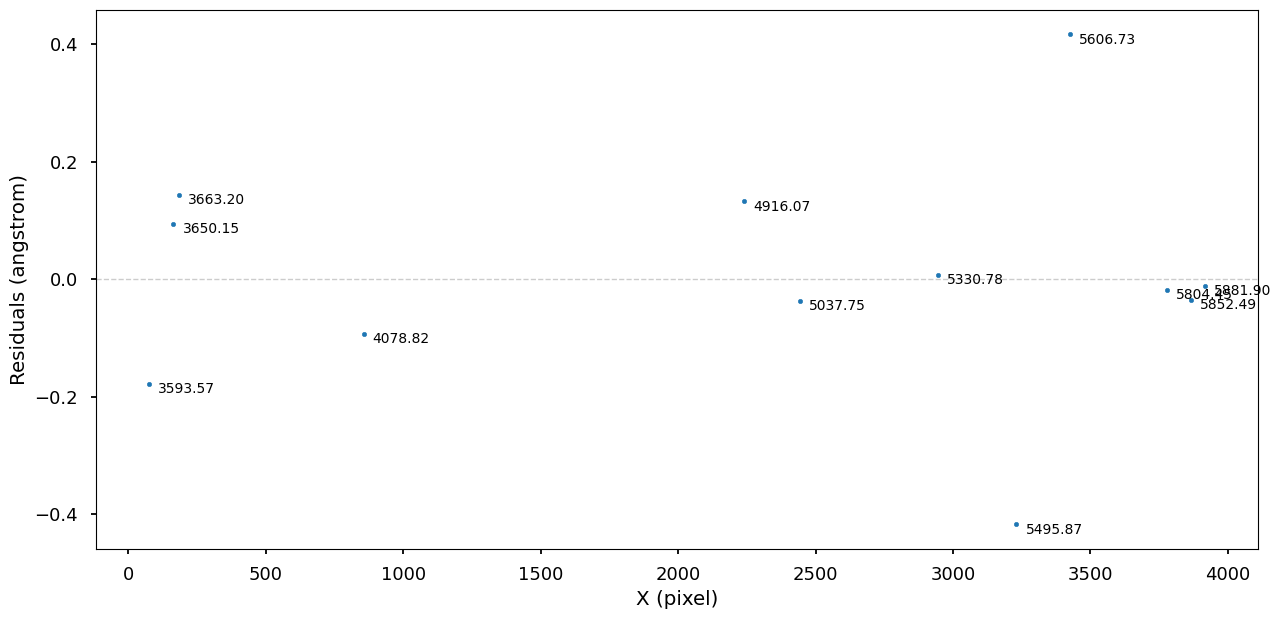

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


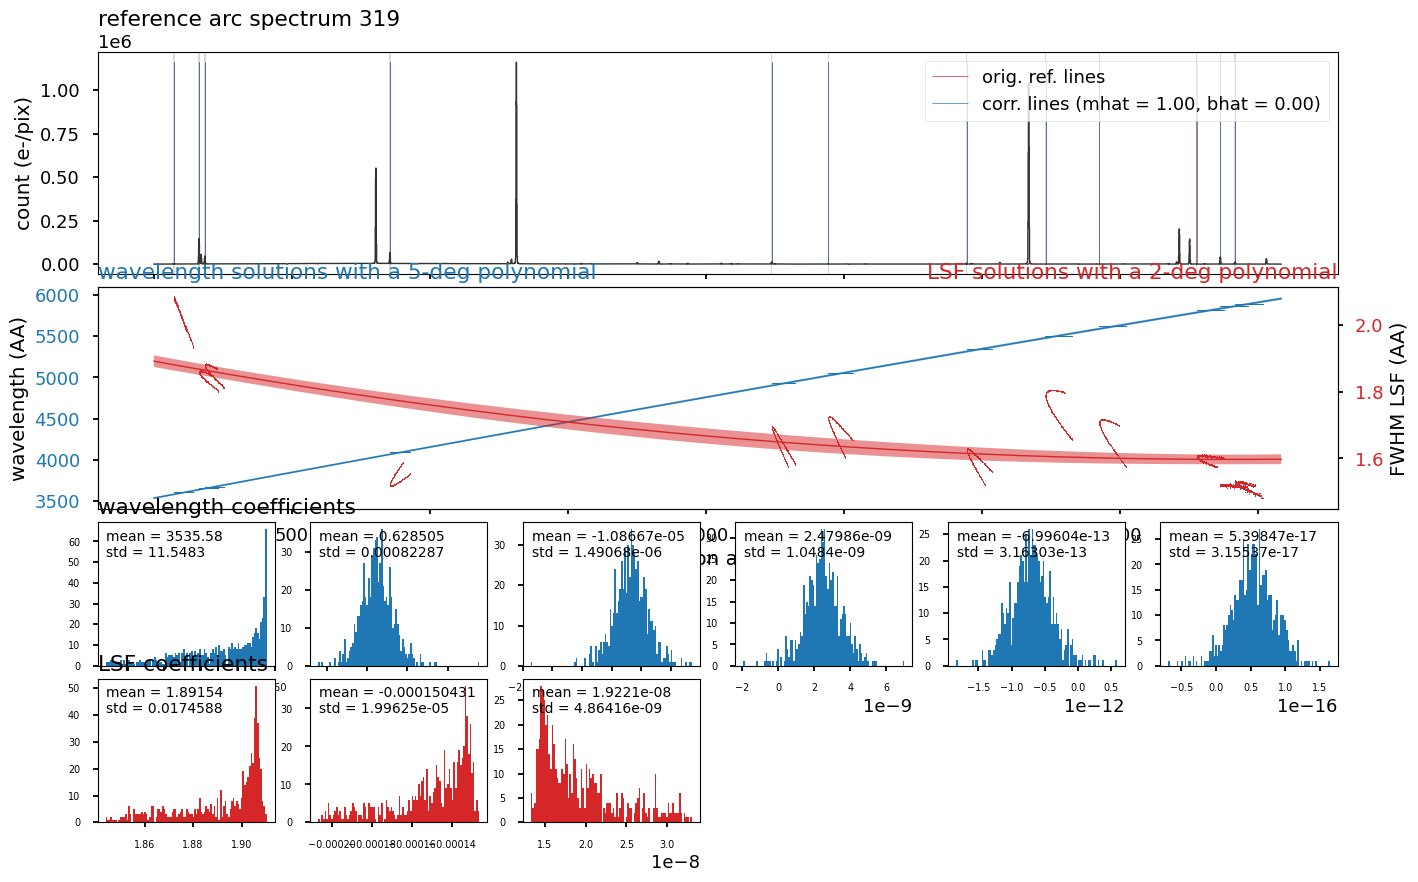

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-b3.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-b3.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r1.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_r1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 32 percentage masked  46.875 %
[INFO]: 17 good lines found
[INFO]: running cross matching on all 32 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r1.fits


[INFO]: max CC = 0.40 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   7%|6         | 22/319 [00:00<00:02, 105.24fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:05<00:00, 62.07fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:04<00:00, 75.12fiber/s] 


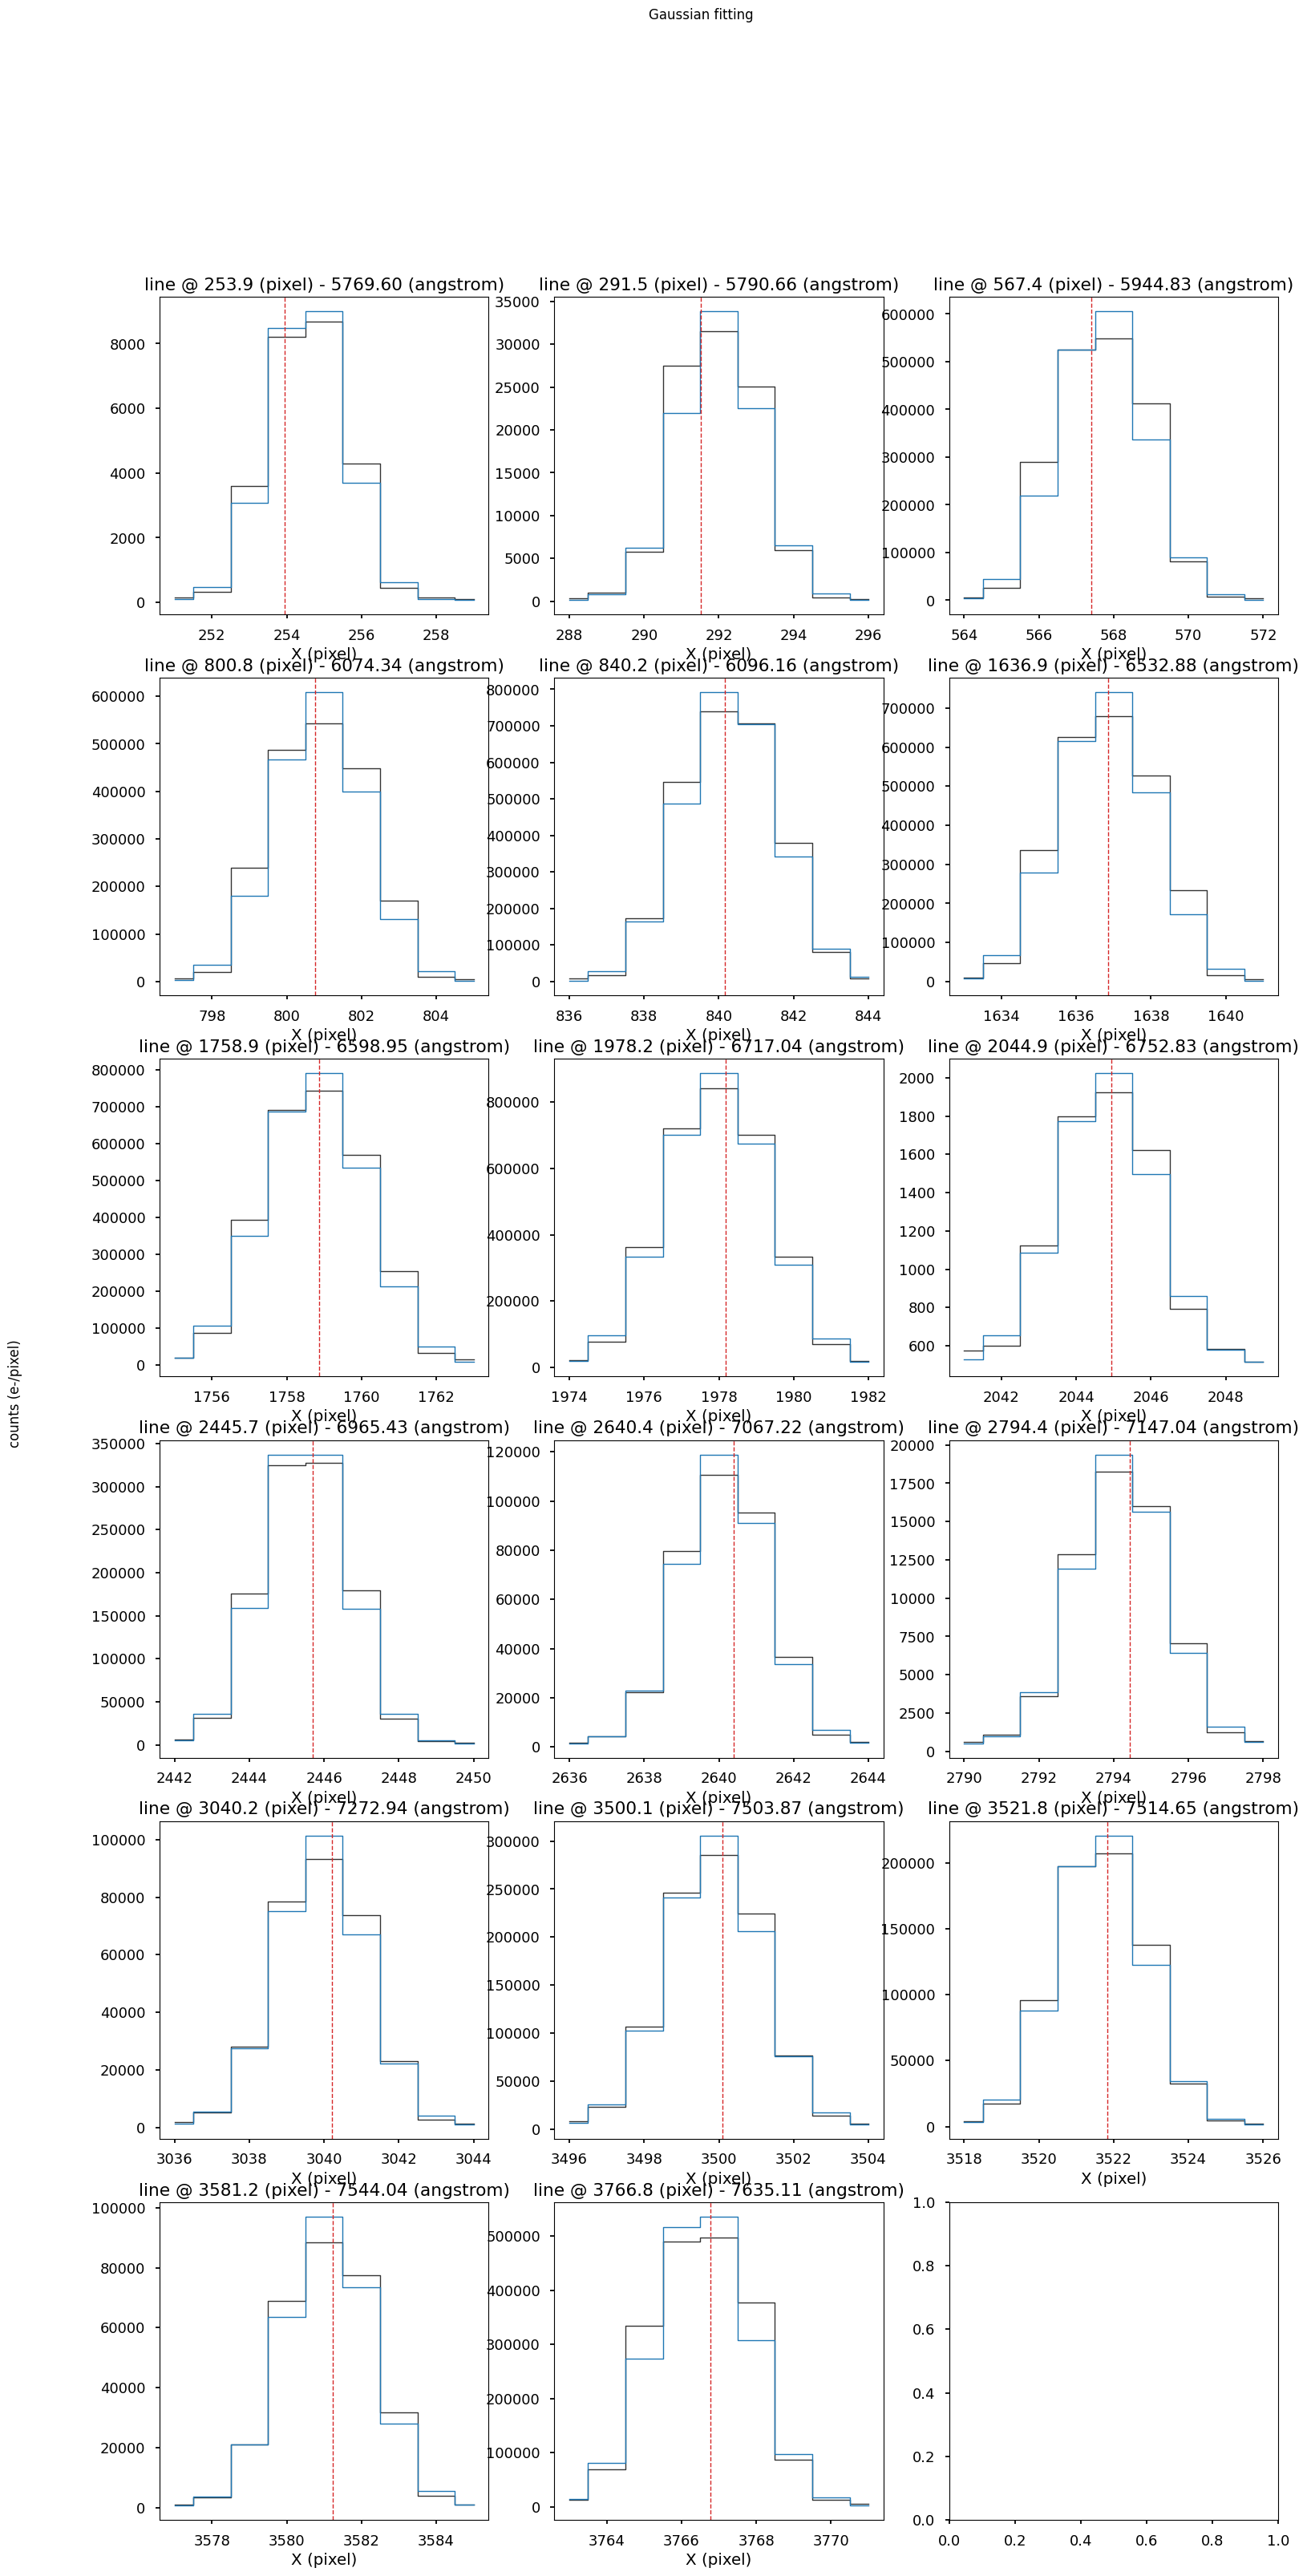

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 49 has all lines masked
[WARNING]: fiber 75 has all lines masked
[WARNING]: fiber 89 has all lines masked
[WARNING]: fiber 100 has all lines masked
[WARNING]: fiber 102 has all lines masked
[WARNING]: fiber 105 has all lines masked
[WARNING]: fiber 160 has all lines masked
[WARNING]: fiber 172 has all lines masked
[WARNING]: fiber 173 has all lines masked
[WARNING]: fiber 183 has all lines masked
[WARNING]: fiber 196 has all lines masked
[WARNING]: fiber 414 has all lines masked
[WARNING]: fiber 462 has all lines masked
[WARNING]: fiber 508 has all lines masked
[WARNING]: fiber 526 has all lines masked
[WARNING]: fiber 539 has all lines masked
[WARNING]: fiber 582 has all lines masked
[WARNING]: fiber 628 has all lines masked
[WARNING]: fiber 630 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 

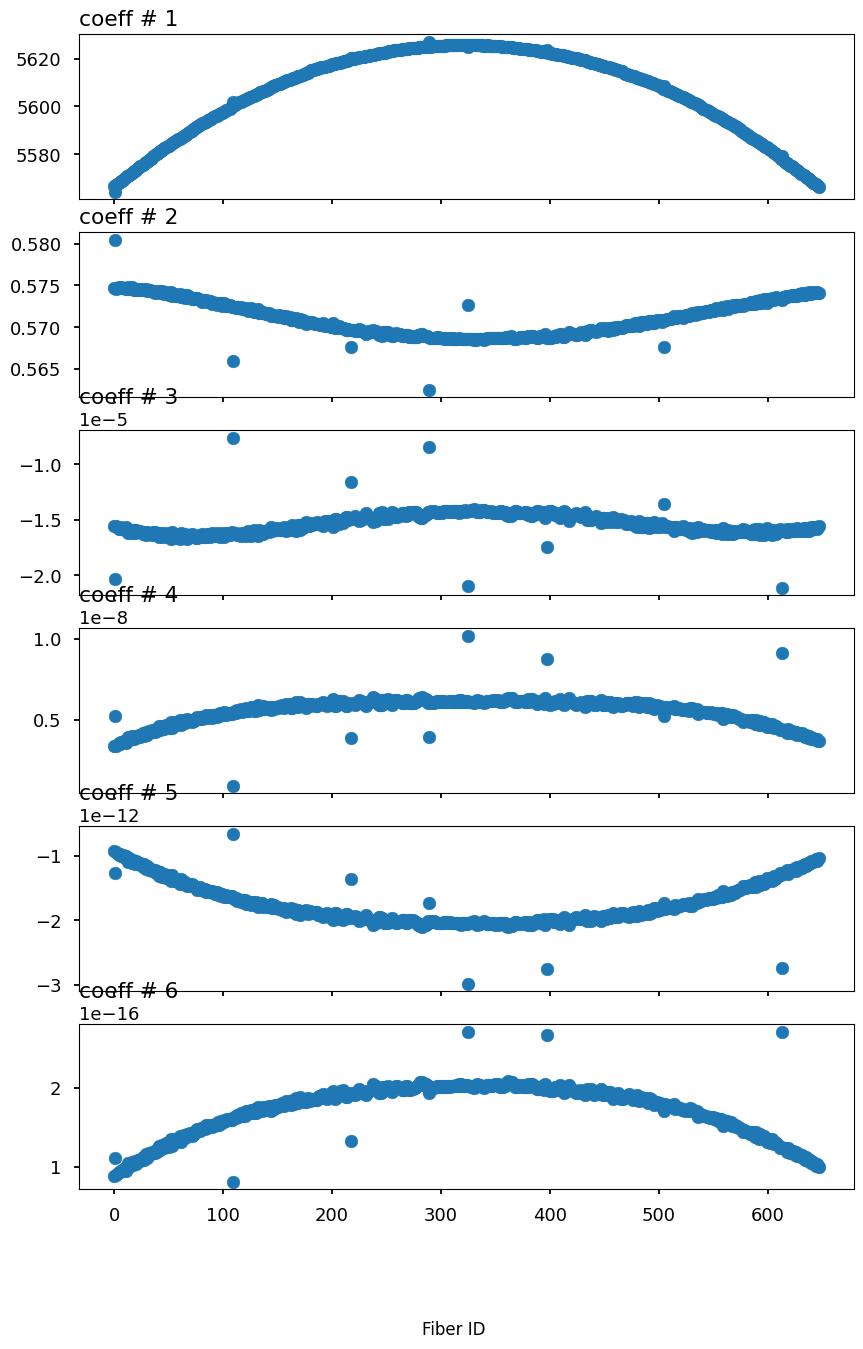

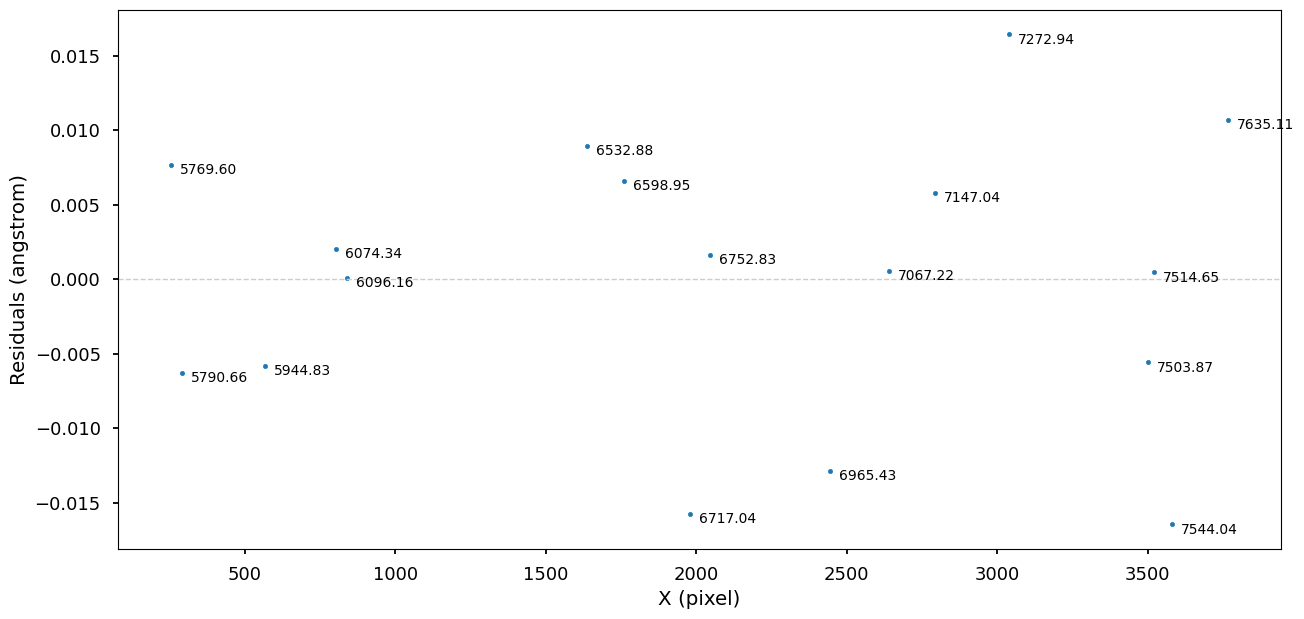

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


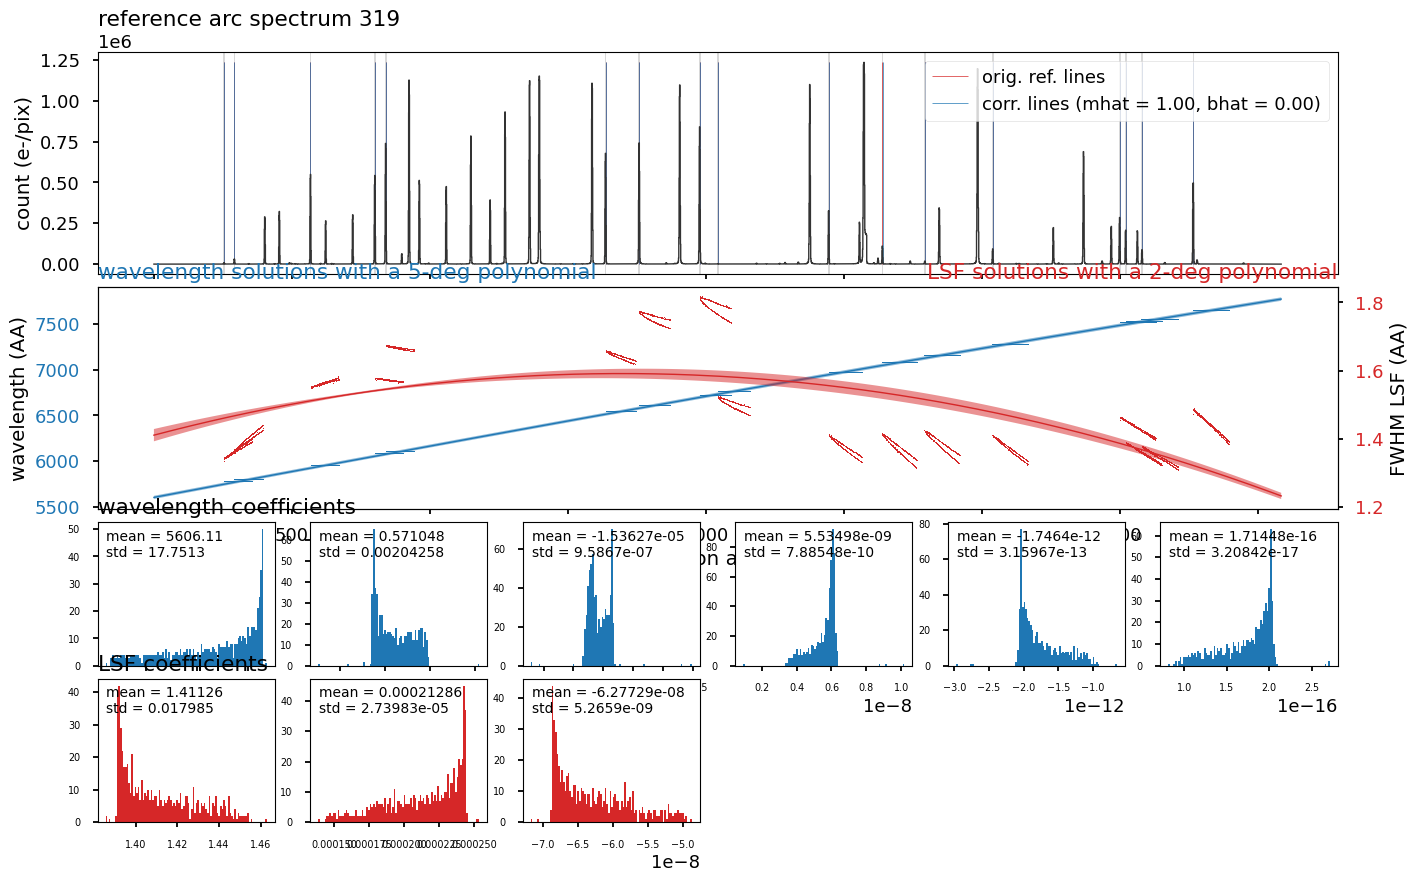

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-r1.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-r1.fits'
[WARNING]: overflow encountered in square (RuntimeWarning)
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r2.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_r2.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 32 percentage masked  53.125 %
[INFO]: 15 good lines found
[INFO]: running cross matching on all 32 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r2.fits


[INFO]: max CC = 0.40 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   7%|6         | 22/319 [00:00<00:02, 103.93fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319:  31%|###1      | 100/319 [00:01<00:02, 106.69fiber/s][WARNING]: divide by zero encountered in divide (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:03<00:00, 90.75fiber/s] 
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:03<00:00, 83.37fiber/s] 


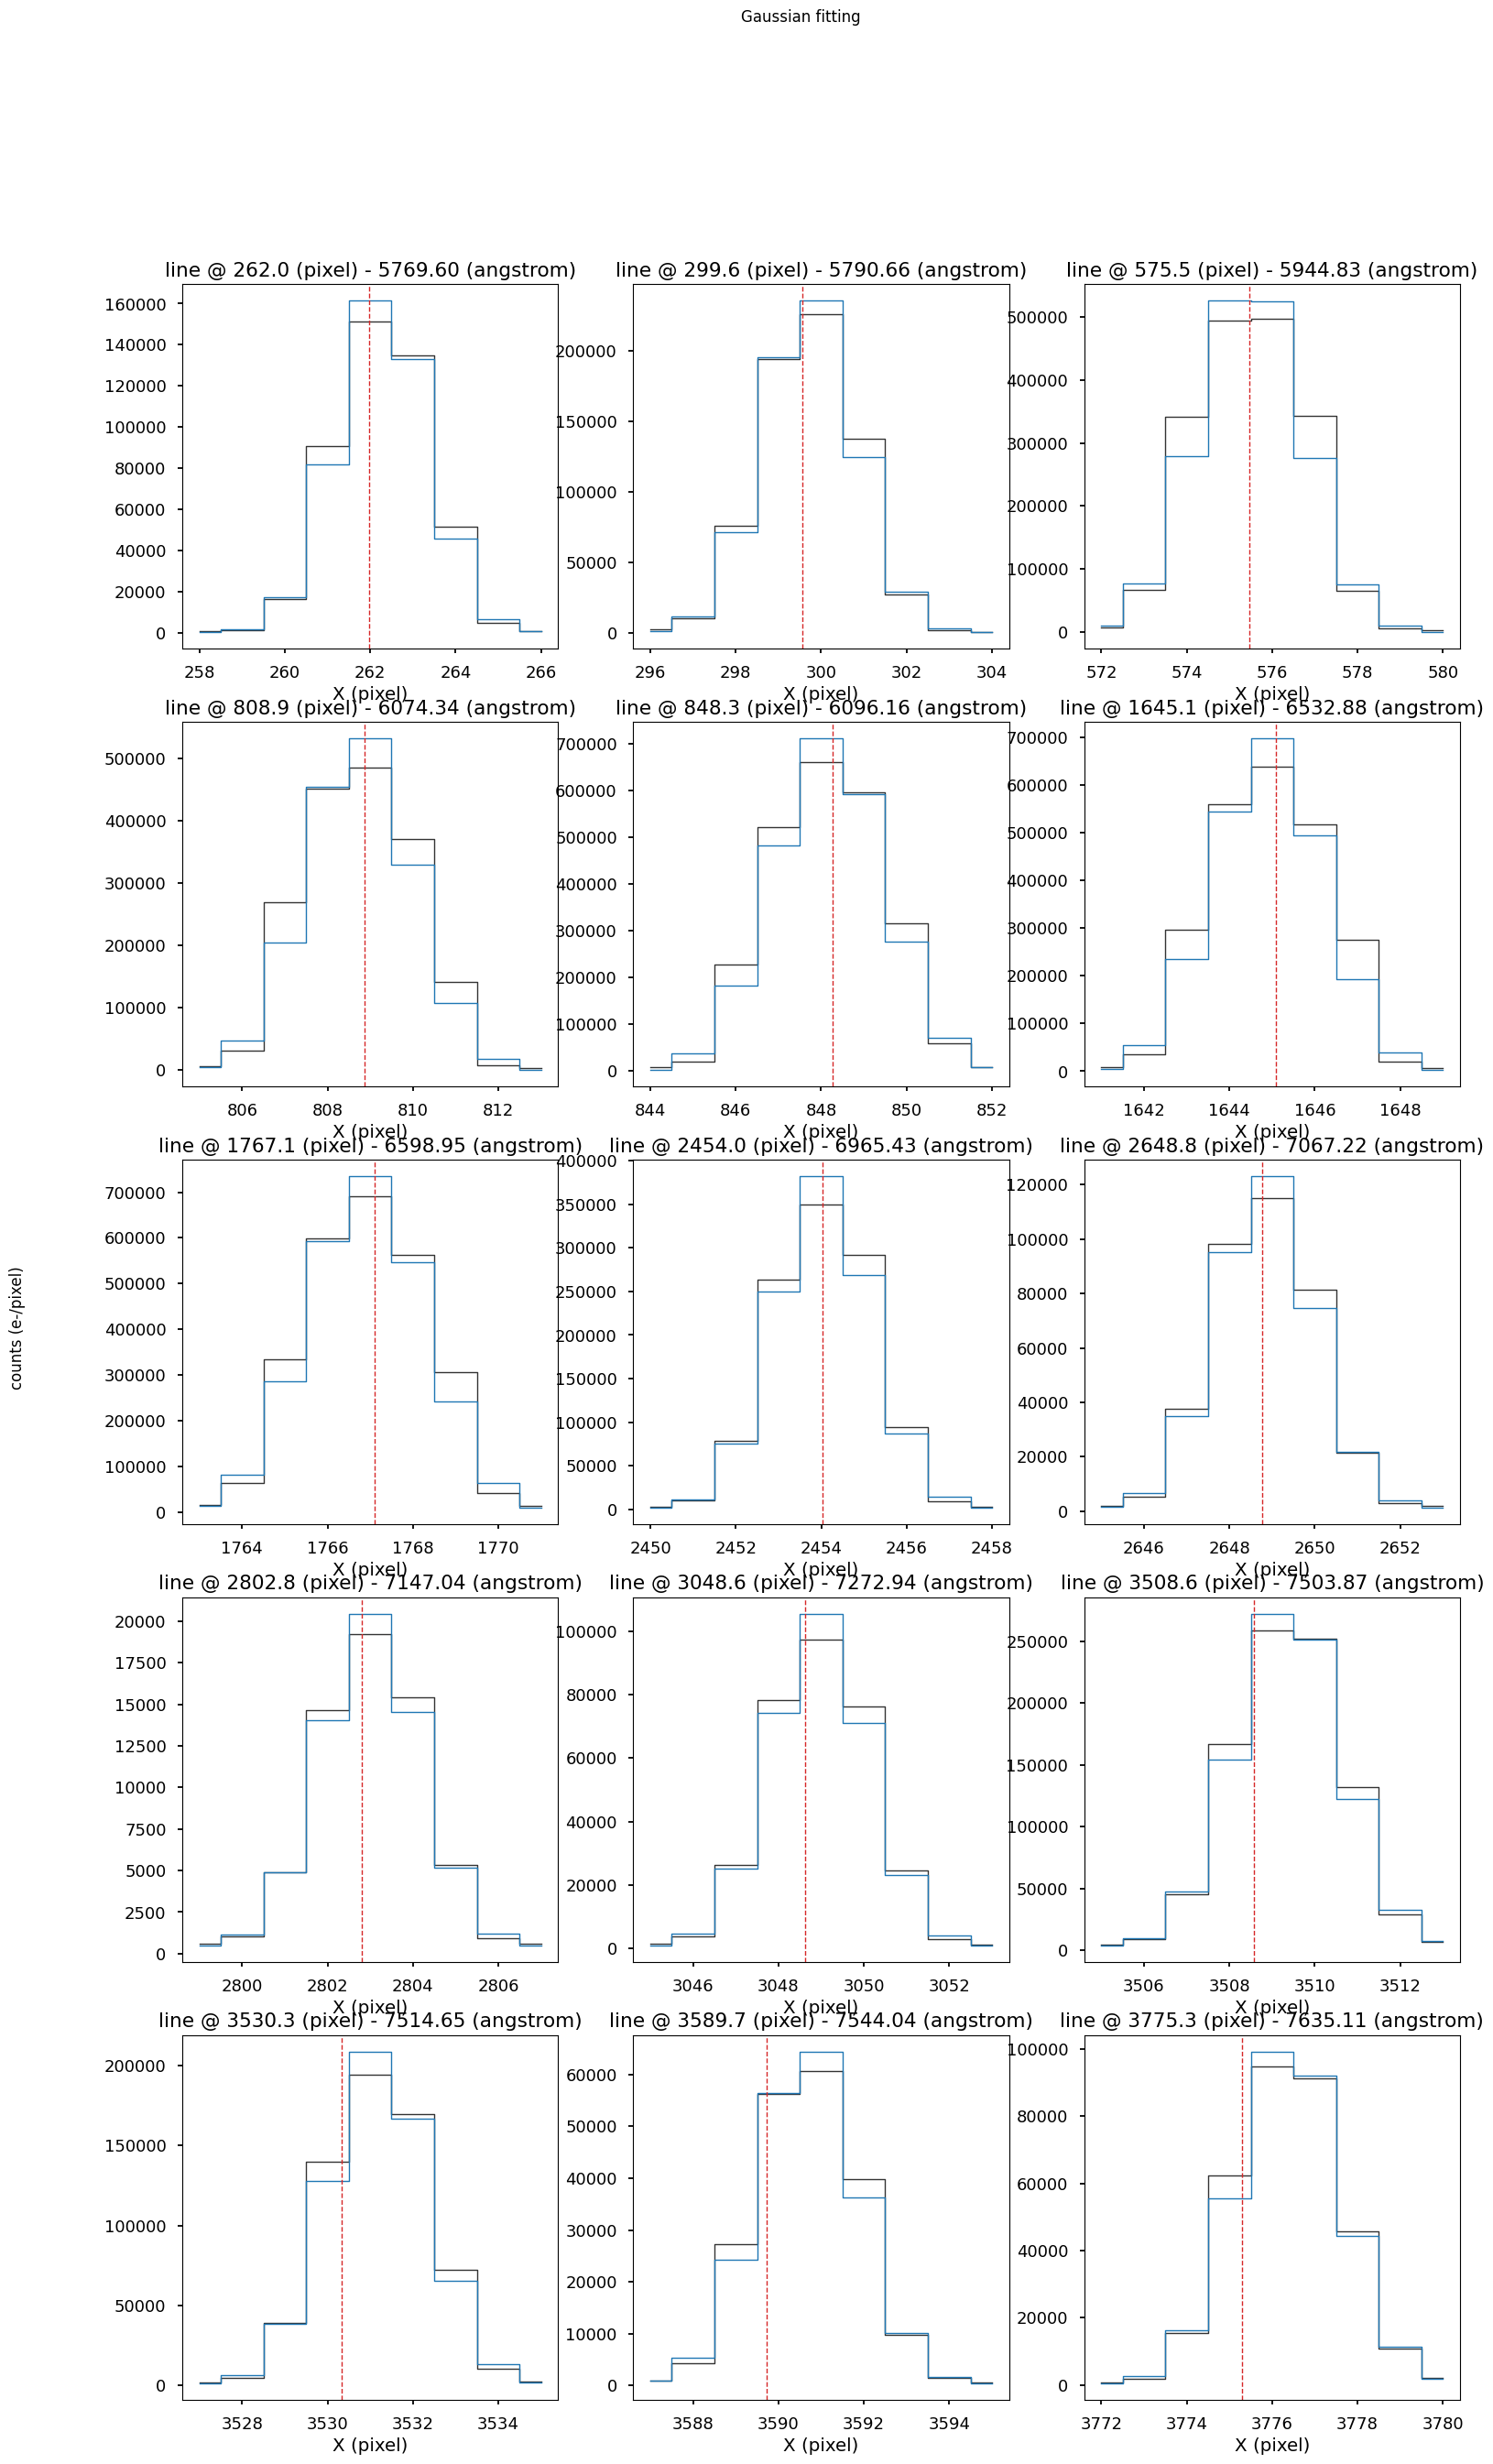

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 1 has all lines masked
[WARNING]: fiber 28 has all lines masked
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 127 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 141 has all lines masked
[WARNING]: fiber 142 has all lines masked
[WARNING]: fiber 157 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 250 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 285 has all lines masked
[WARNING]: fiber 289 has all lines masked
[WARNING]: fiber 335 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 445 has all lines masked
[WARNING]: fiber 455 has all lines masked
[WARNING]: fiber 506 has all lines masked
[WARNING]: fiber 512 has all lines masked
[WARNING]: fi

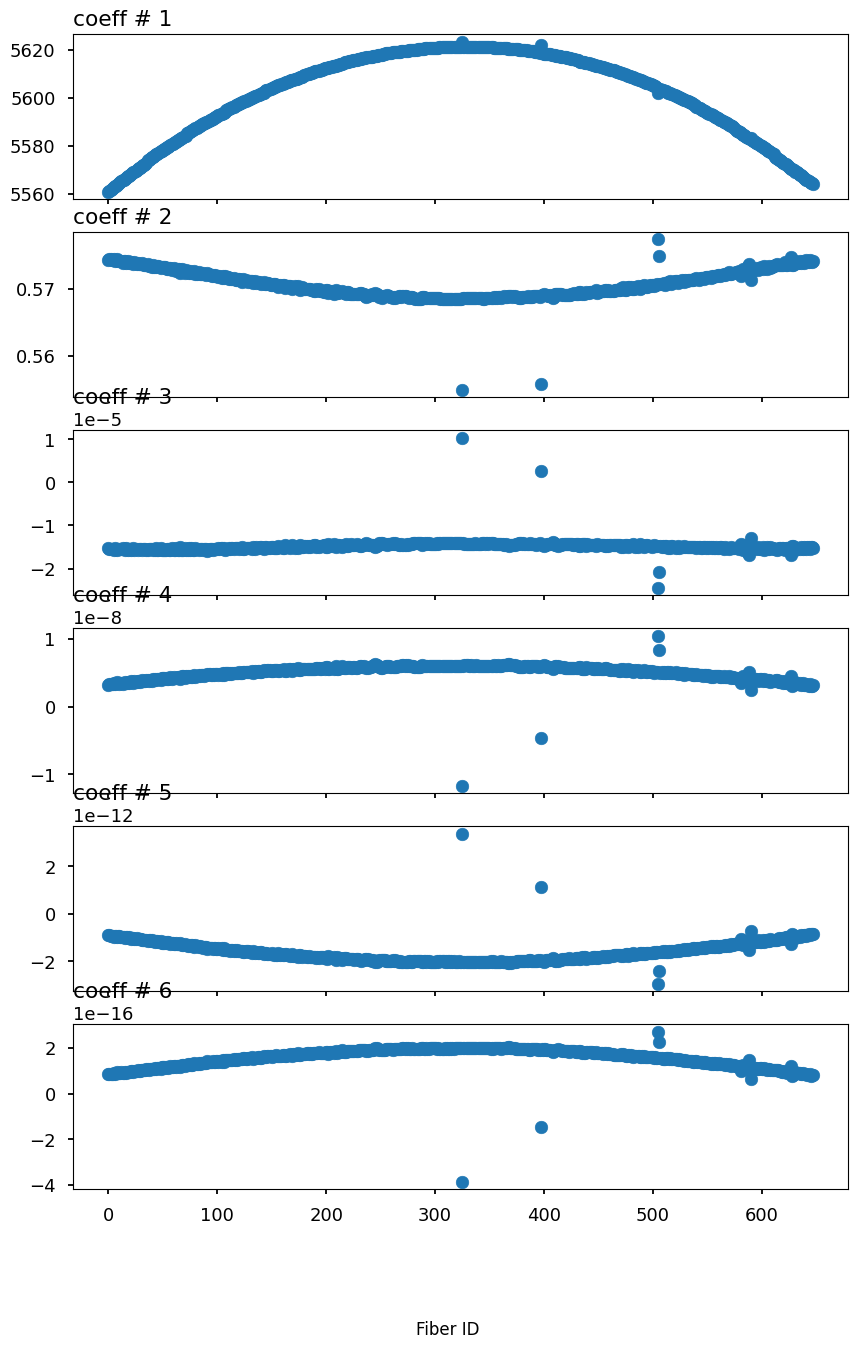

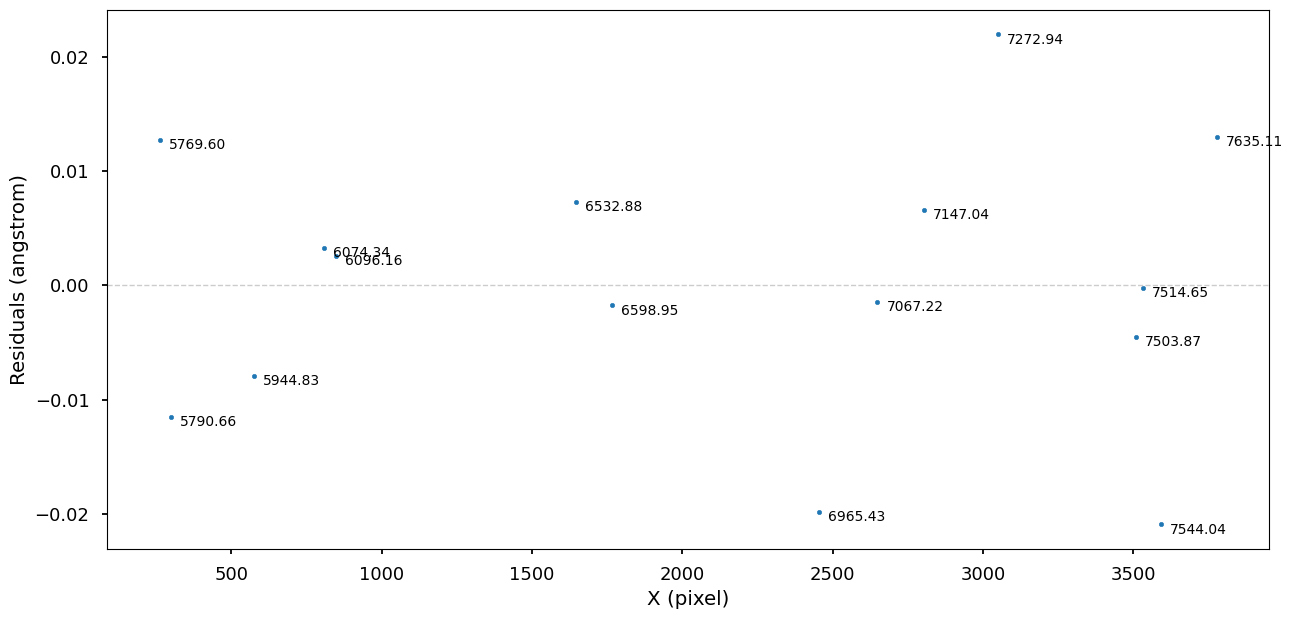

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


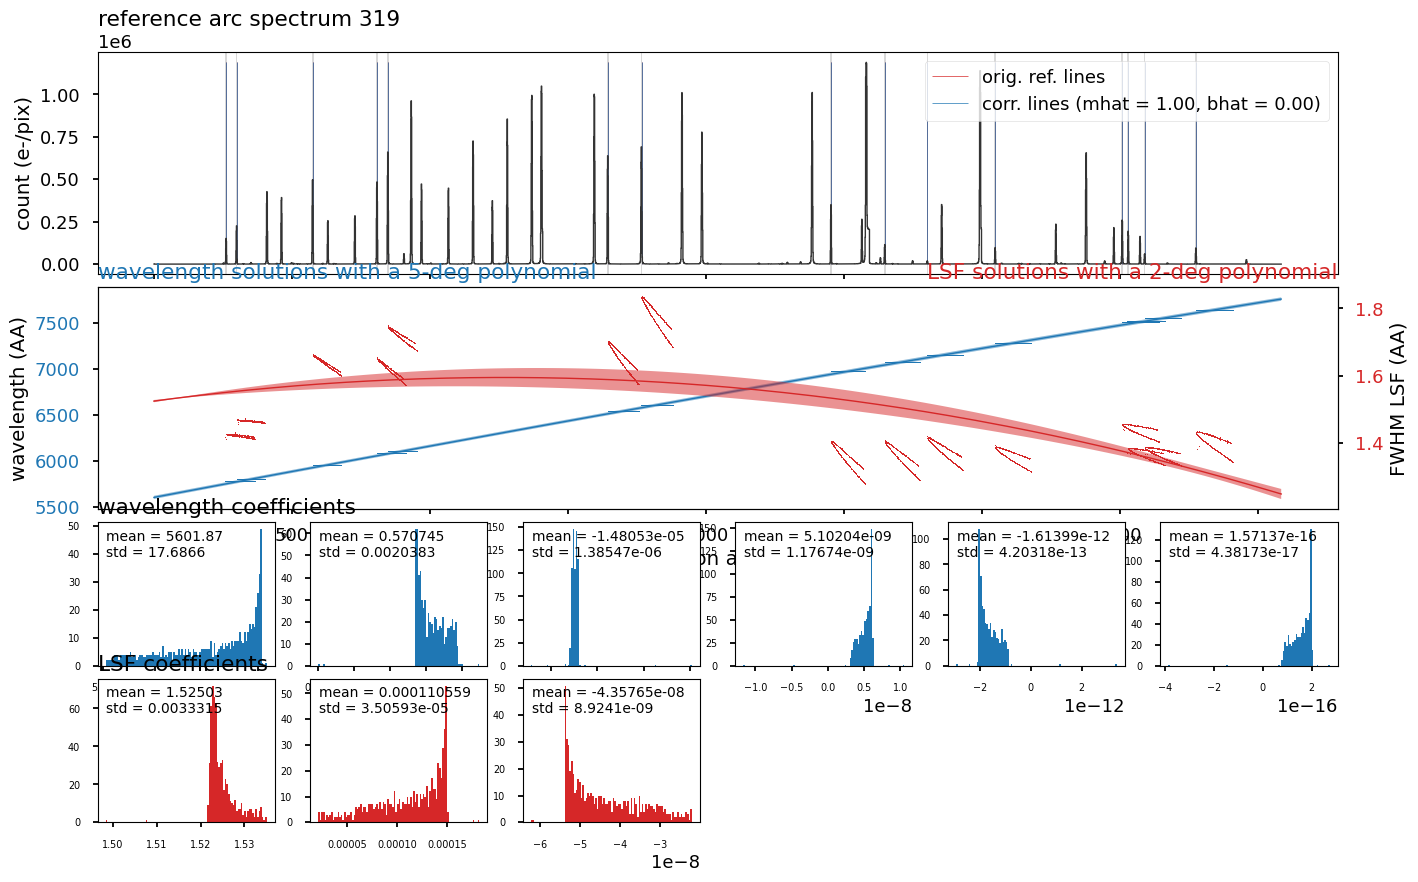

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-r2.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-r2.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r3.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_r3.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 32 percentage masked  53.125 %
[INFO]: 15 good lines found
[INFO]: running cross matching on all 32 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-r3.fits


[INFO]: max CC = 0.40 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   8%|7         | 24/319 [00:00<00:02, 116.44fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:03<00:00, 83.60fiber/s] 
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:04<00:00, 72.67fiber/s] 


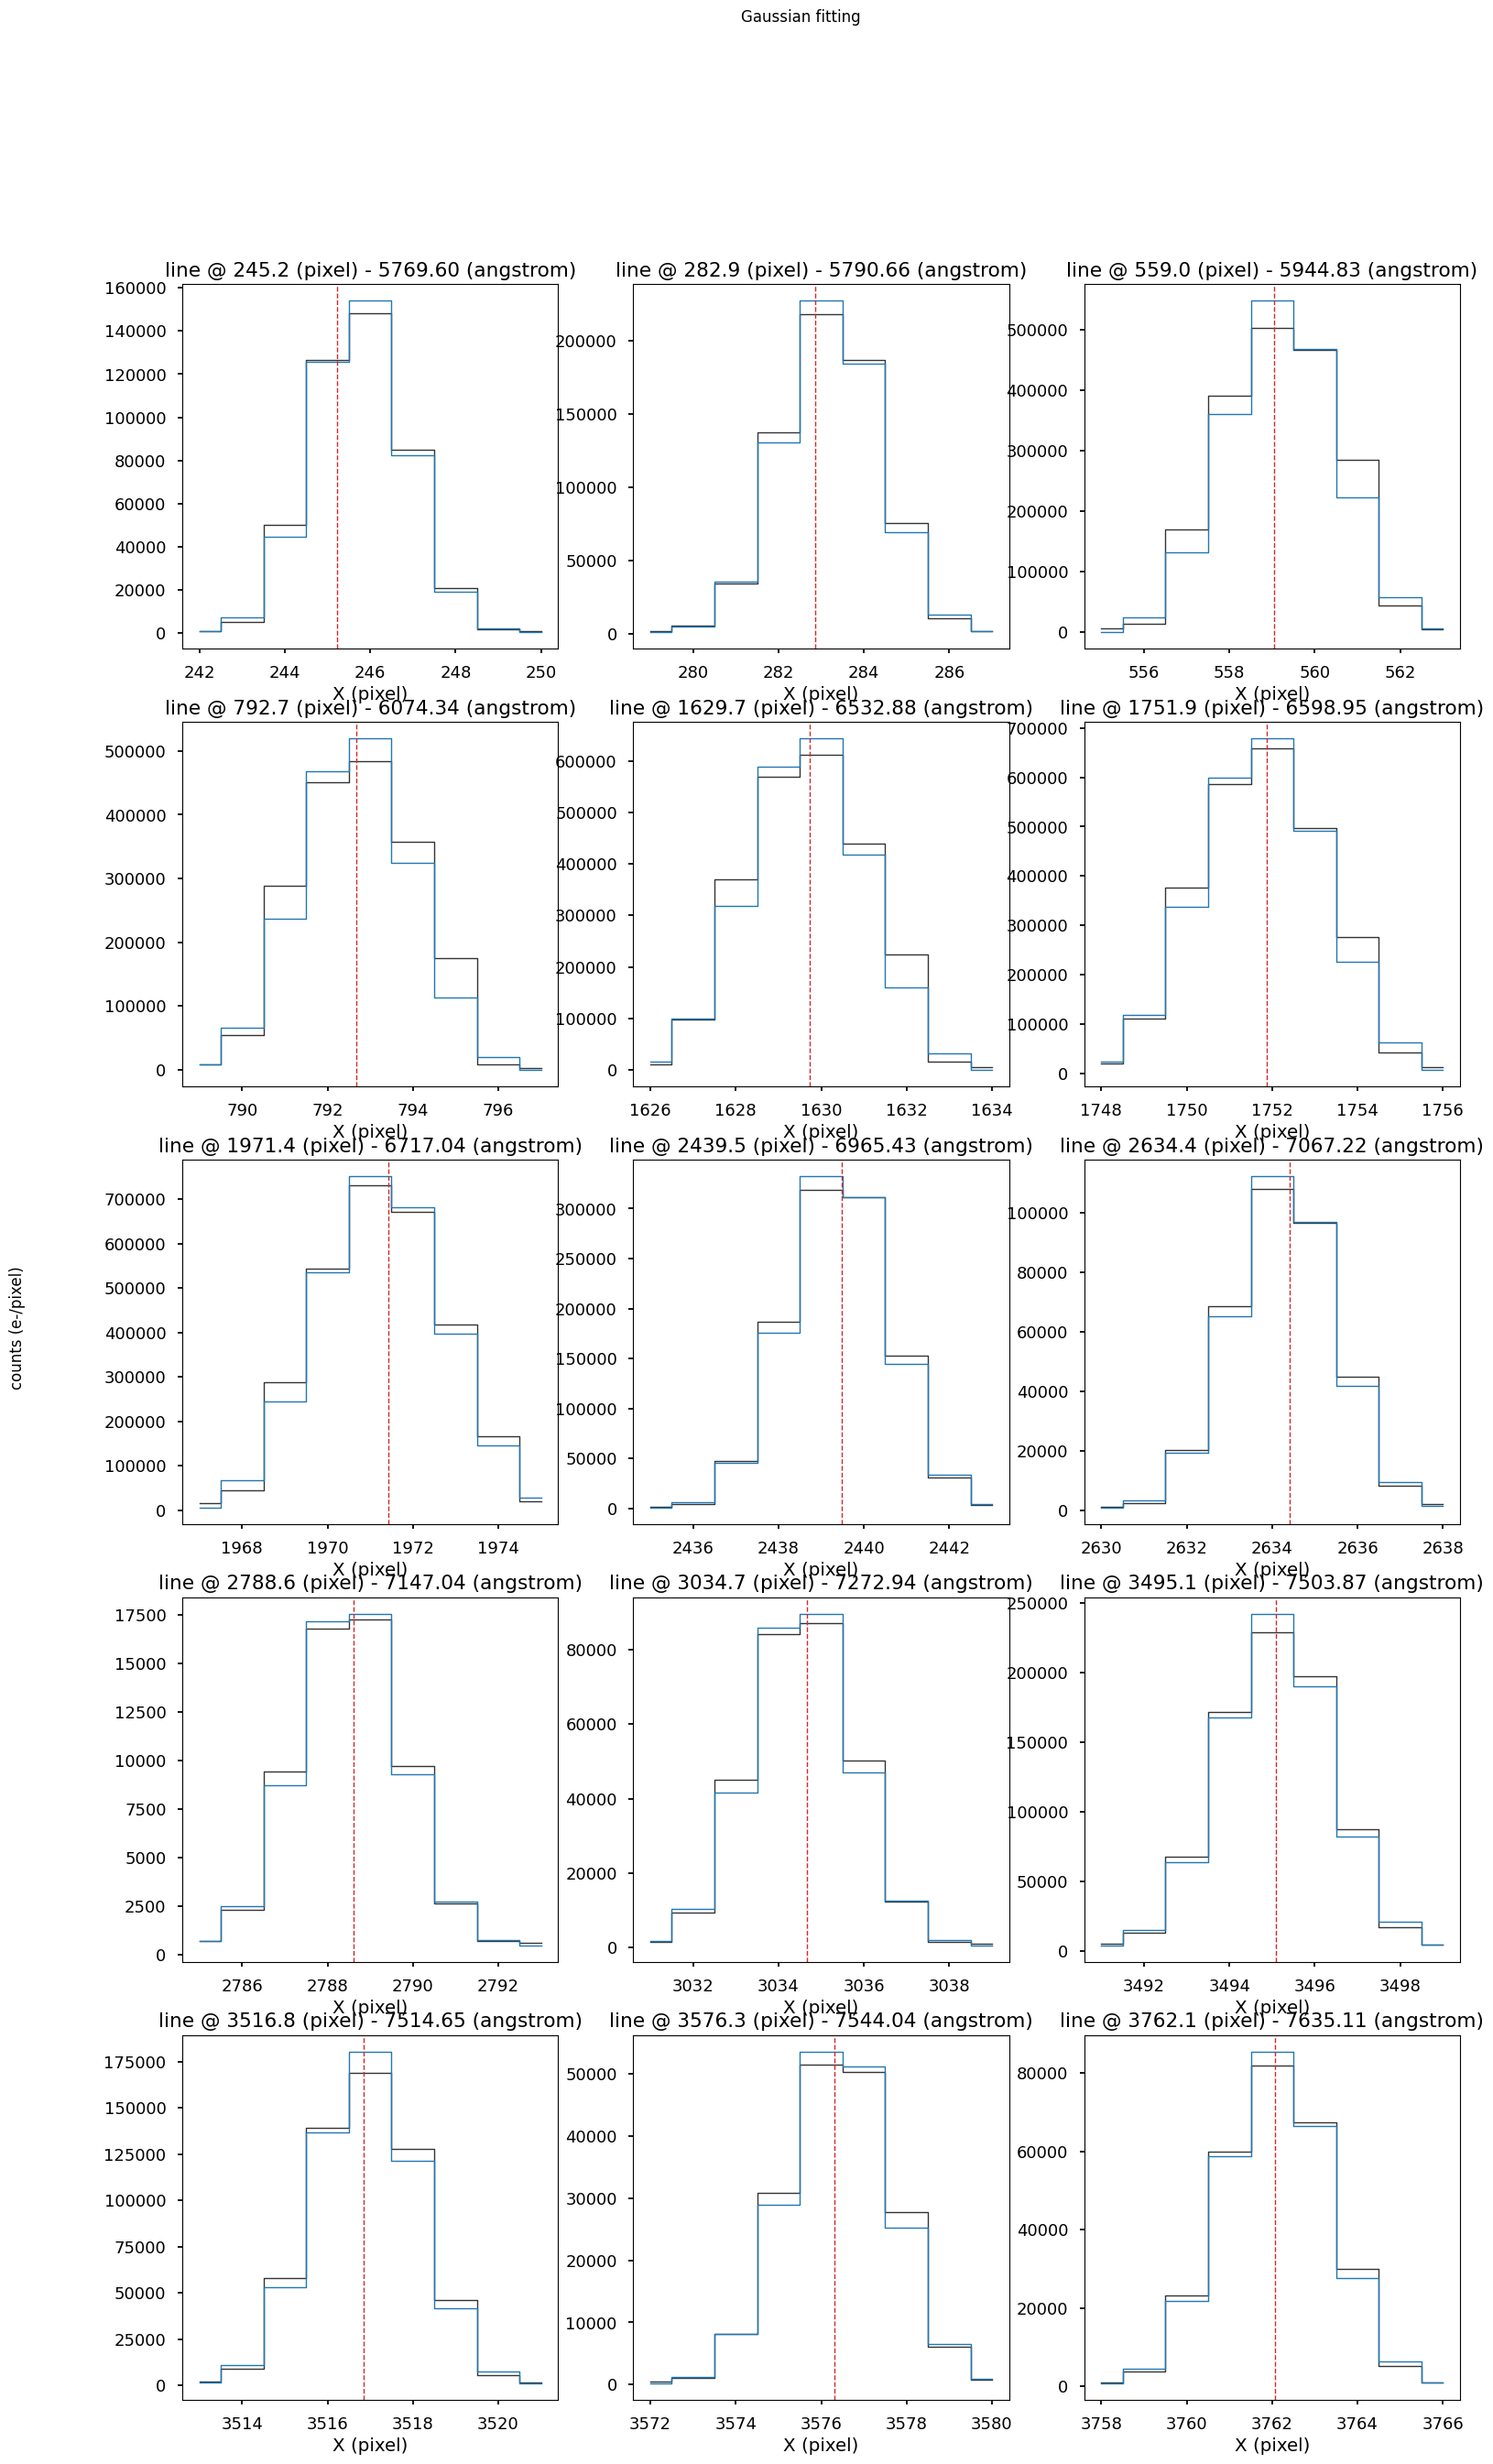

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 397 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 447 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: fiber 506 has all lines masked
[WARNING]: fiber 512 has all lines masked
[WARNING]: fiber 556 has all lines masked
[WARNING]: fiber 563 has all lines masked
[WARNING]: fiber 575 has all lines masked
[WARNING]: fiber 580 has all lines masked
[WARNING]: fiber 613 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 0.012012 AA (0.0227587 pix)
[INFO]: fitting LSF solutions using 2-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.122522 AA (0.22914 pix)


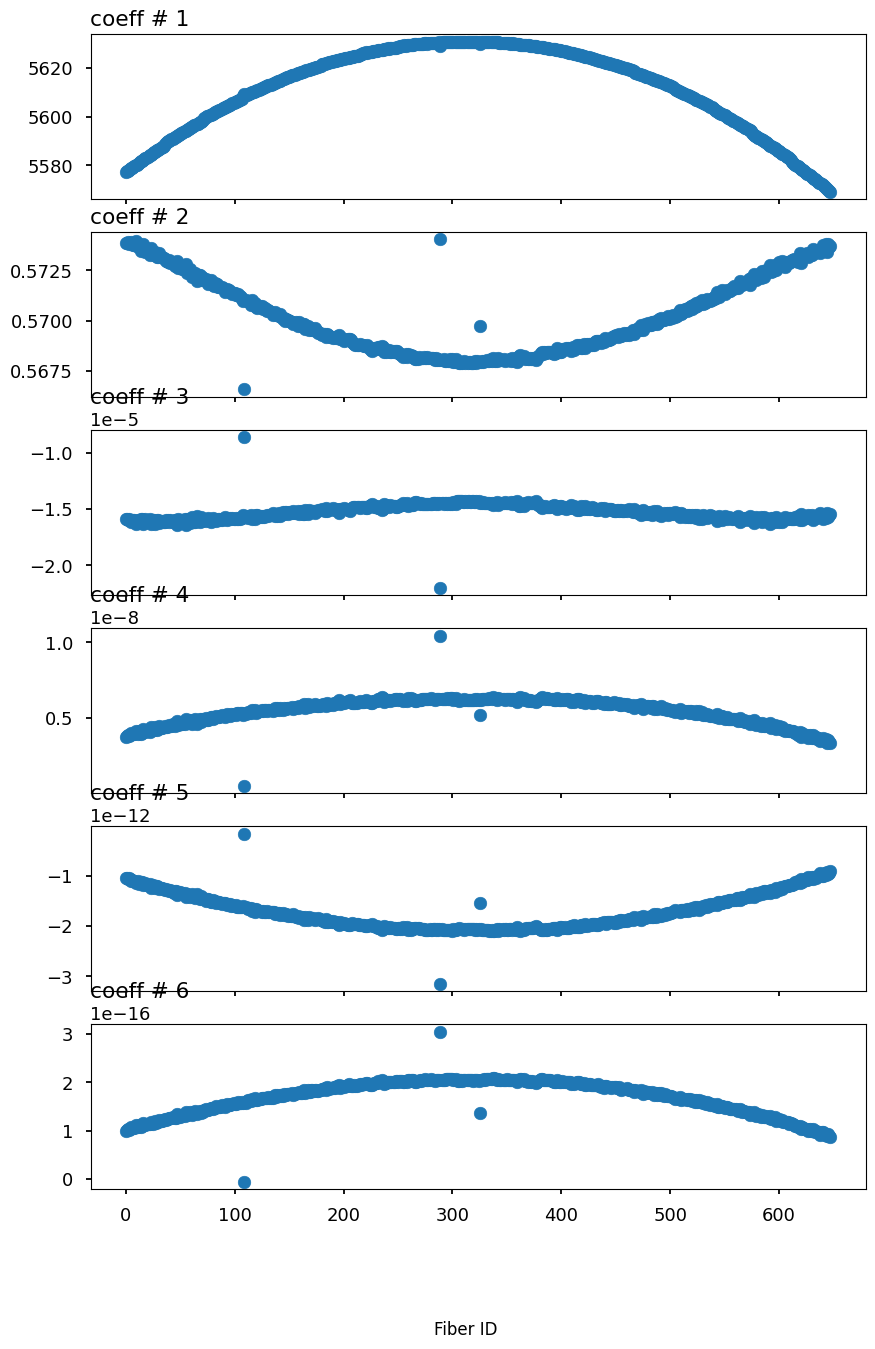

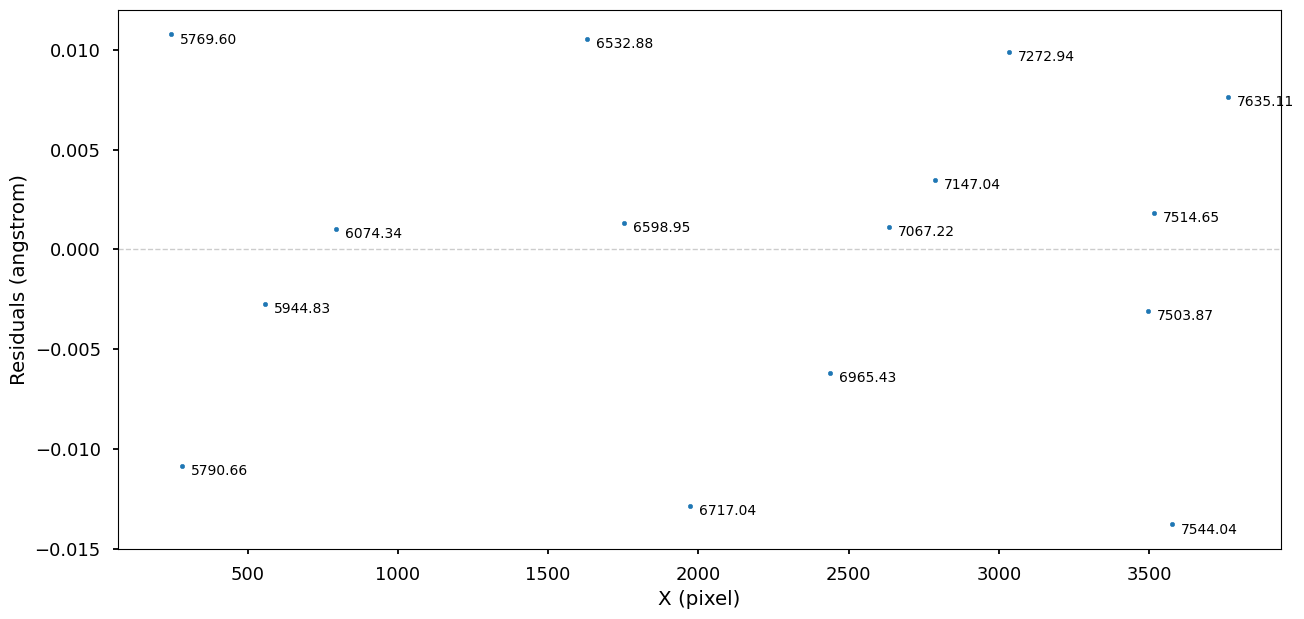

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


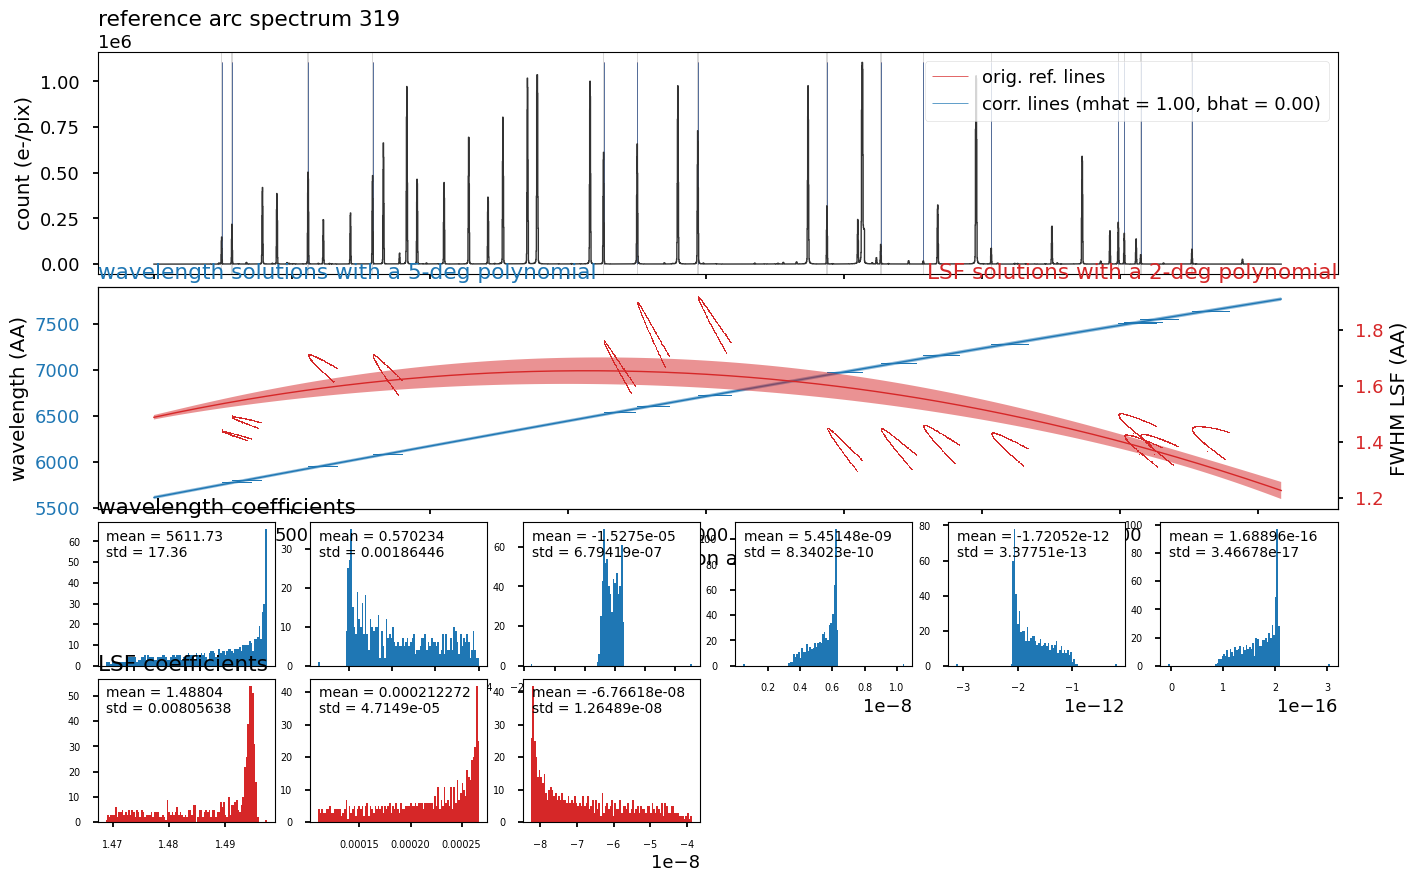

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-r3.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-r3.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z1.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_z1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 34 percentage masked  35.2941 %
[INFO]: 22 good lines found
[INFO]: running cross matching on all 34 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z1.fits


[INFO]: max CC = 0.24 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   8%|8         | 27/319 [00:00<00:03, 85.72fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319:  71%|#######   | 226/319 [00:04<00:02, 41.93fiber/s][WARNING]: divide by zero encountered in divide (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:05<00:00, 54.25fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:05<00:00, 59.24fiber/s]


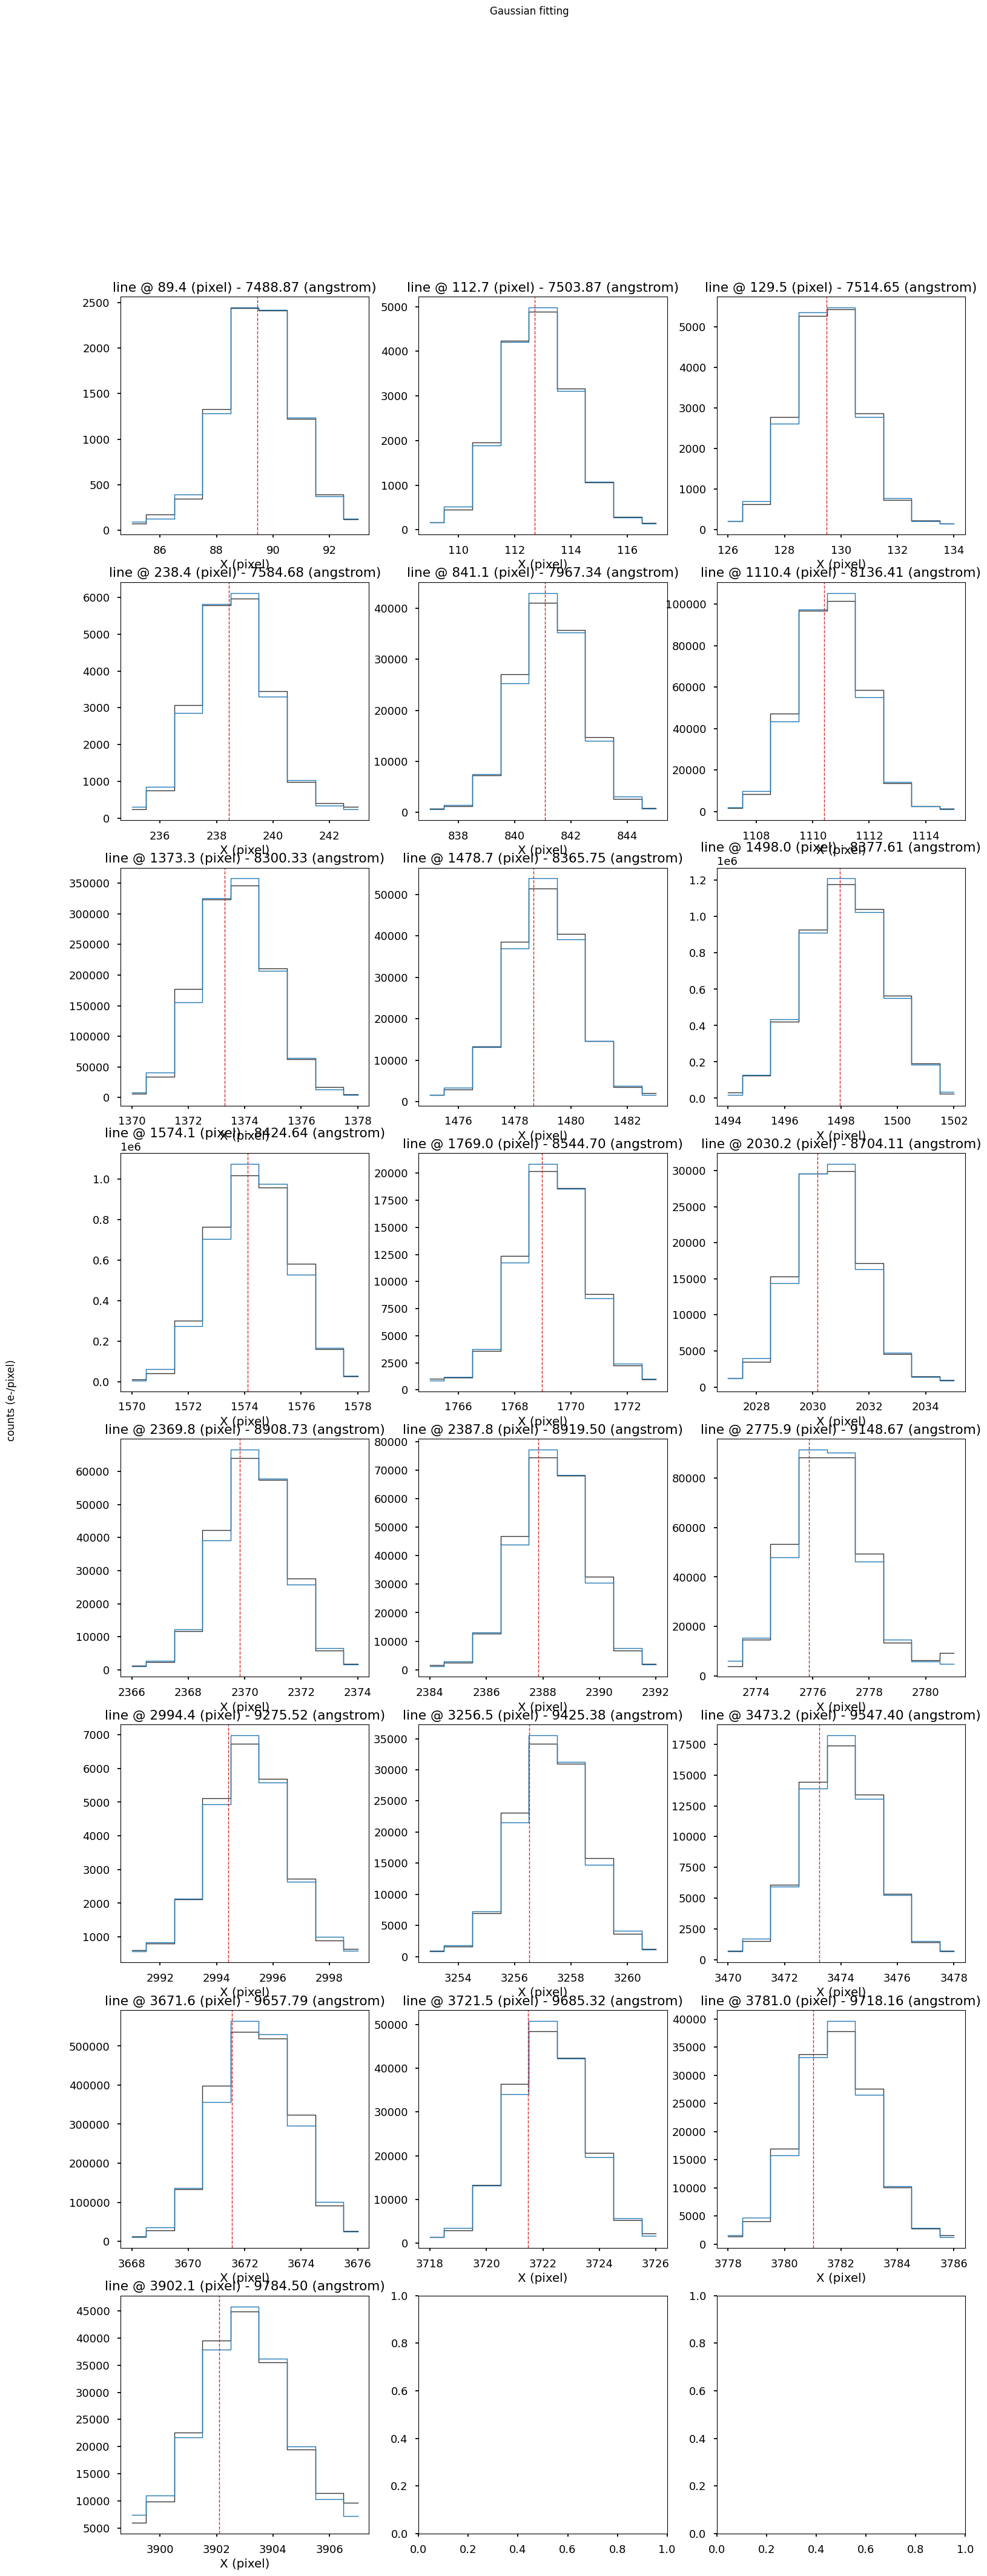

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 1 has all lines masked
[WARNING]: fiber 49 has all lines masked
[WARNING]: fiber 75 has all lines masked
[WARNING]: fiber 89 has all lines masked
[WARNING]: fiber 100 has all lines masked
[WARNING]: fiber 102 has all lines masked
[WARNING]: fiber 105 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 160 has all lines masked
[WARNING]: fiber 172 has all lines masked
[WARNING]: fiber 173 has all lines masked
[WARNING]: fiber 183 has all lines masked
[WARNING]: fiber 196 has all lines masked
[WARNING]: fiber 325 has all lines masked
[WARNING]: fiber 414 has all lines masked
[WARNING]: fiber 462 has all lines masked
[WARNING]: fiber 508 has all lines masked
[WARNING]: fiber 526 has all lines masked
[WARNING]: fiber 539 has all lines masked
[WARNING]: fiber 582 has all lines masked
[WARNING]: fib

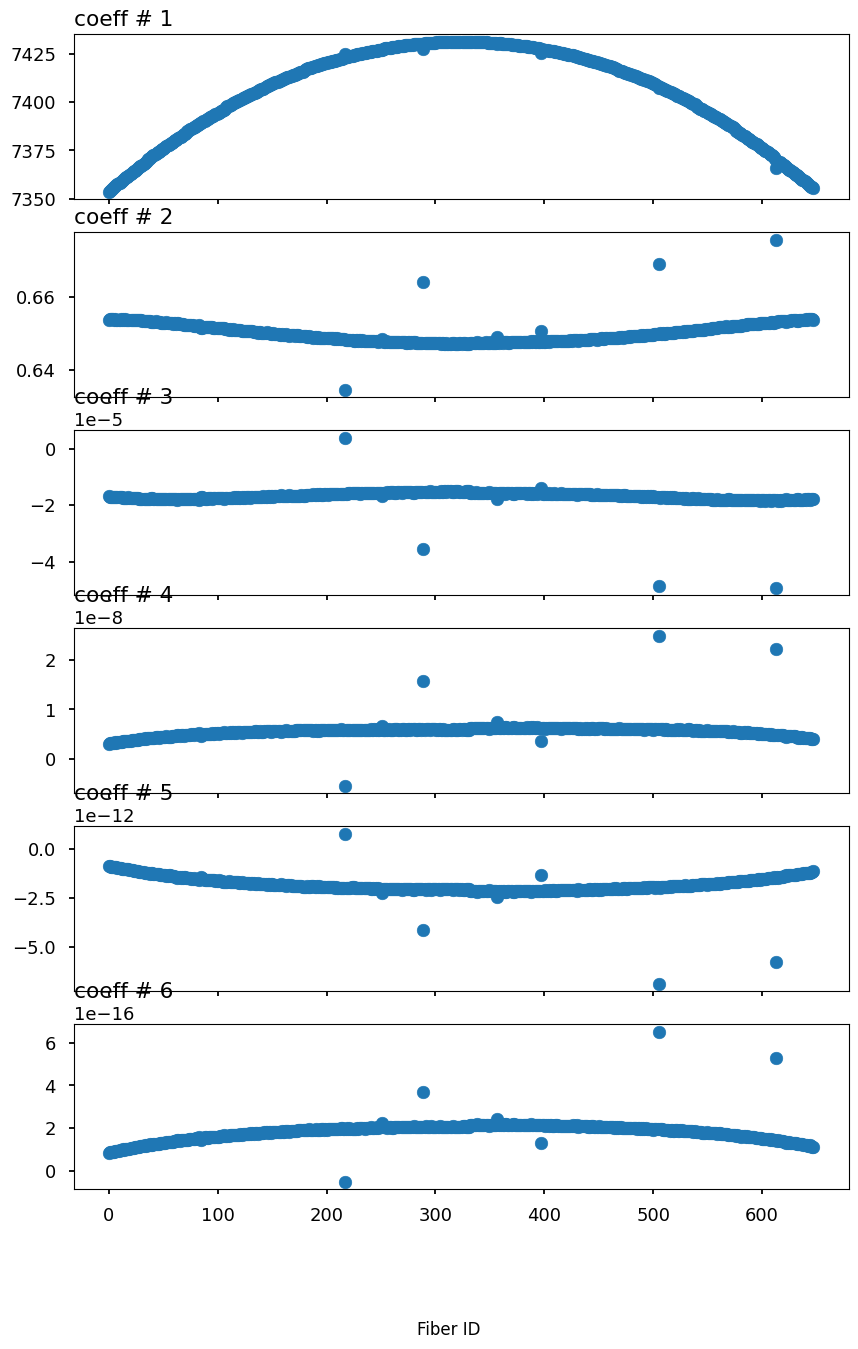

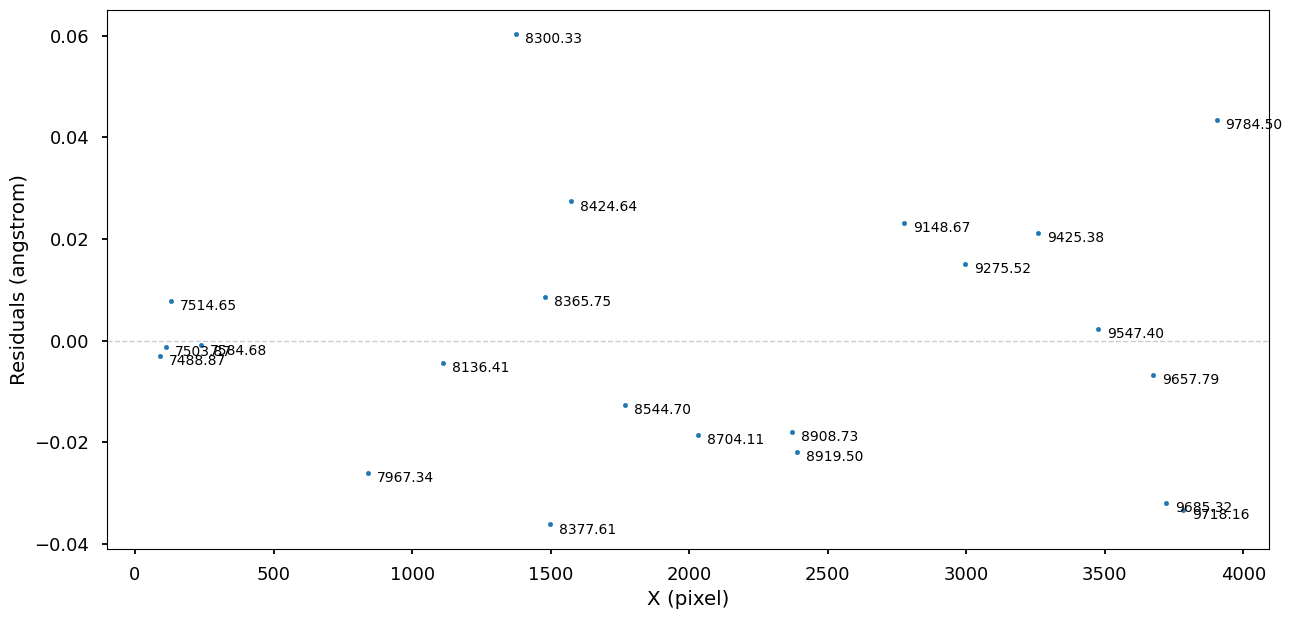

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


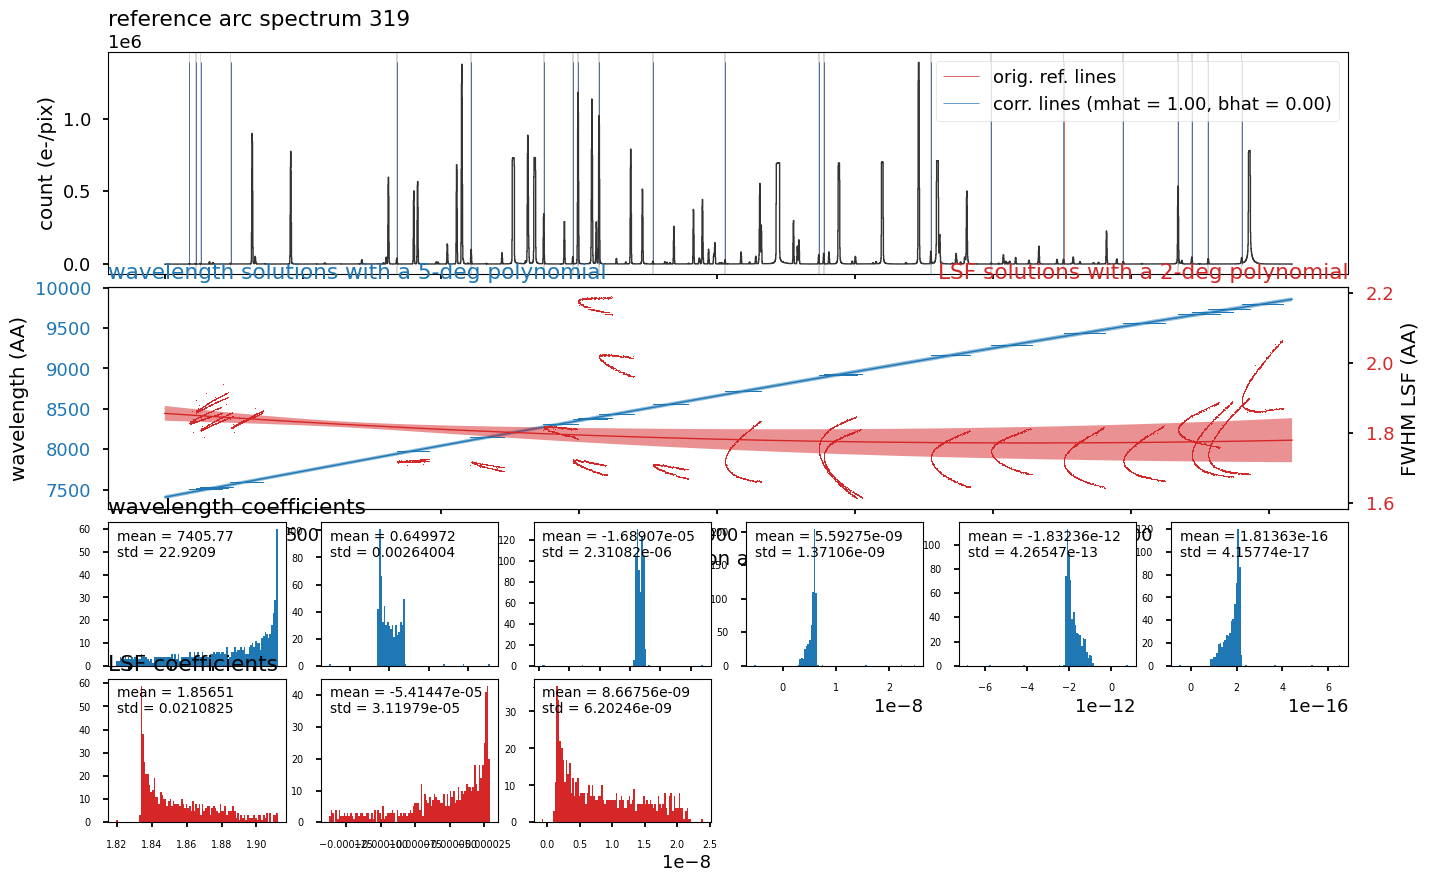

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-z1.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-z1.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z2.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_z2.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 35 percentage masked  34.2857 %
[INFO]: 23 good lines found
[INFO]: running cross matching on all 35 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z2.fits


[INFO]: max CC = 0.23 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   8%|7         | 24/319 [00:00<00:03, 77.83fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:05<00:00, 56.69fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:07<00:00, 45.29fiber/s]


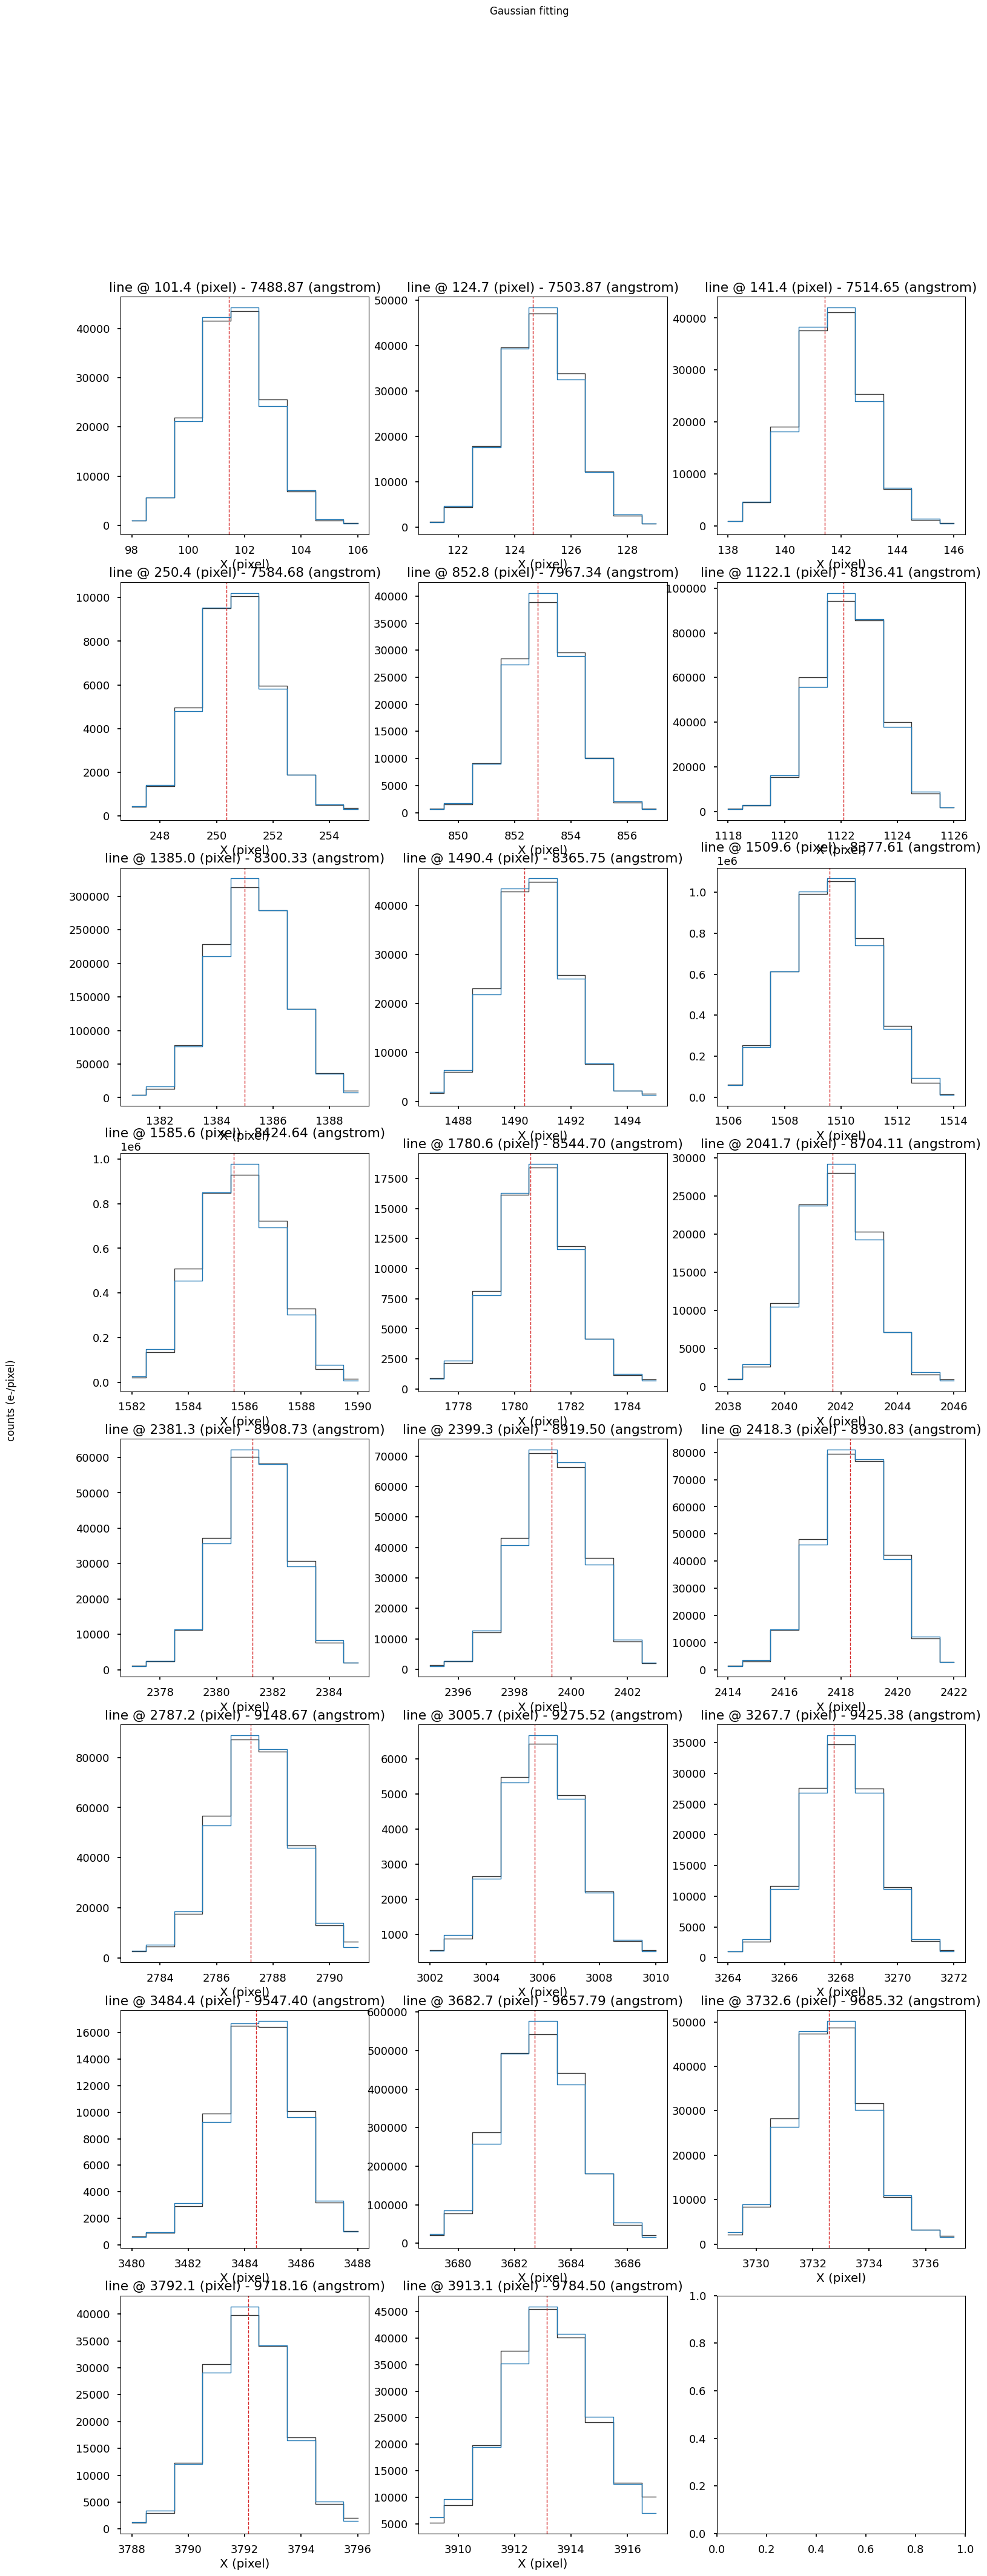

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 28 has all lines masked
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 127 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 141 has all lines masked
[WARNING]: fiber 142 has all lines masked
[WARNING]: fiber 157 has all lines masked
[WARNING]: fiber 250 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 285 has all lines masked
[WARNING]: fiber 335 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 445 has all lines masked
[WARNING]: fiber 455 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: fiber 506 has all lines masked
[WARNING]: fiber 512 has all lines masked
[WARNING]: fiber 557 has all lines masked
[WARNING]: fiber 563 has all lines masked
[WARNING]: fiber 580 has all lines masked
[INFO]: fin

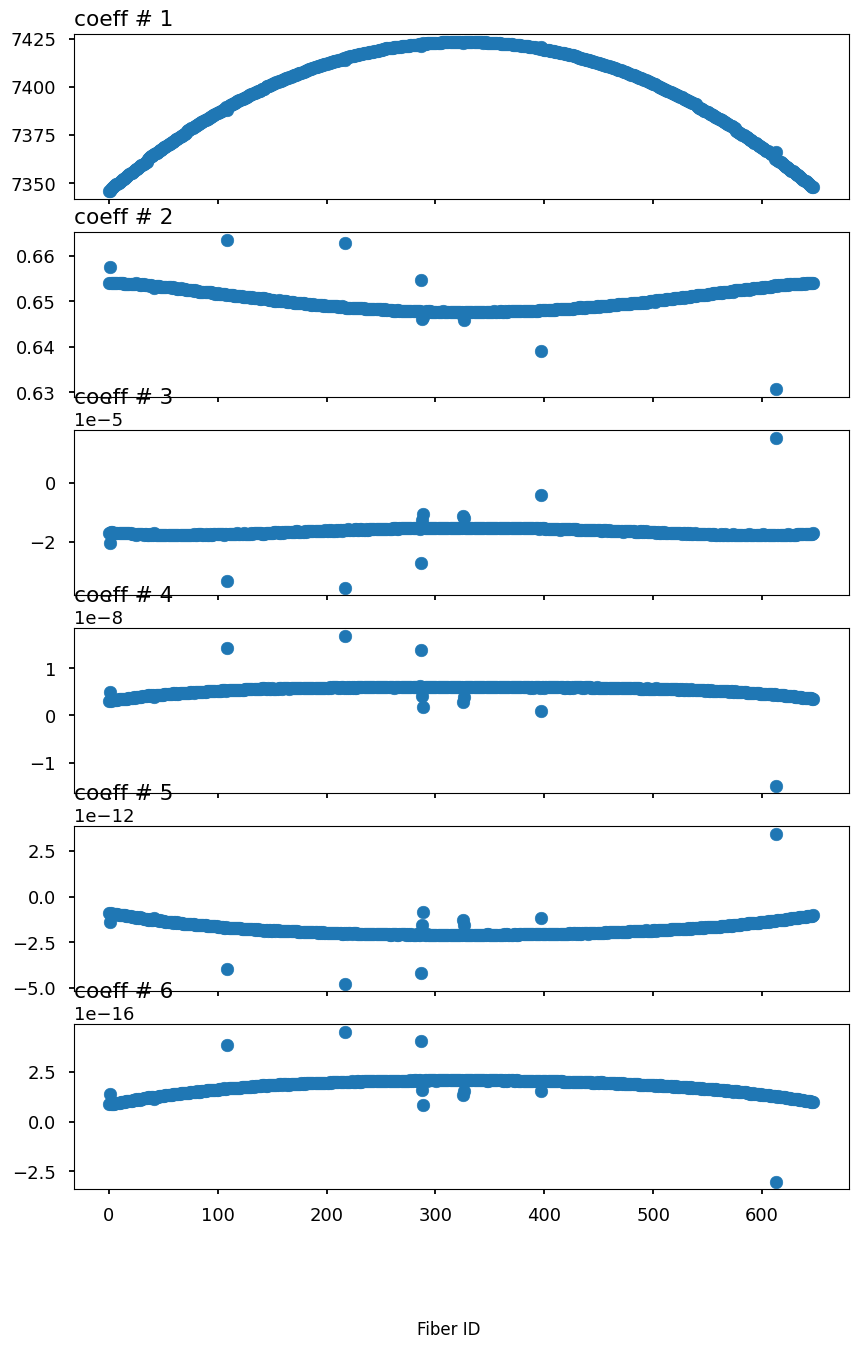

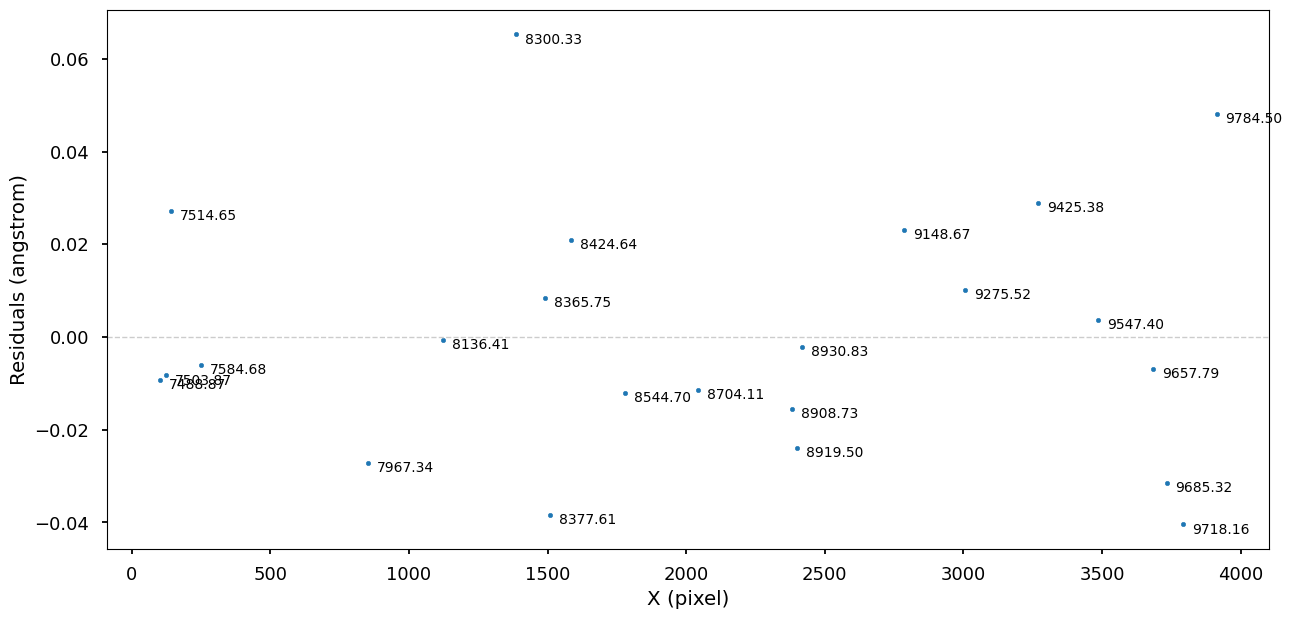

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


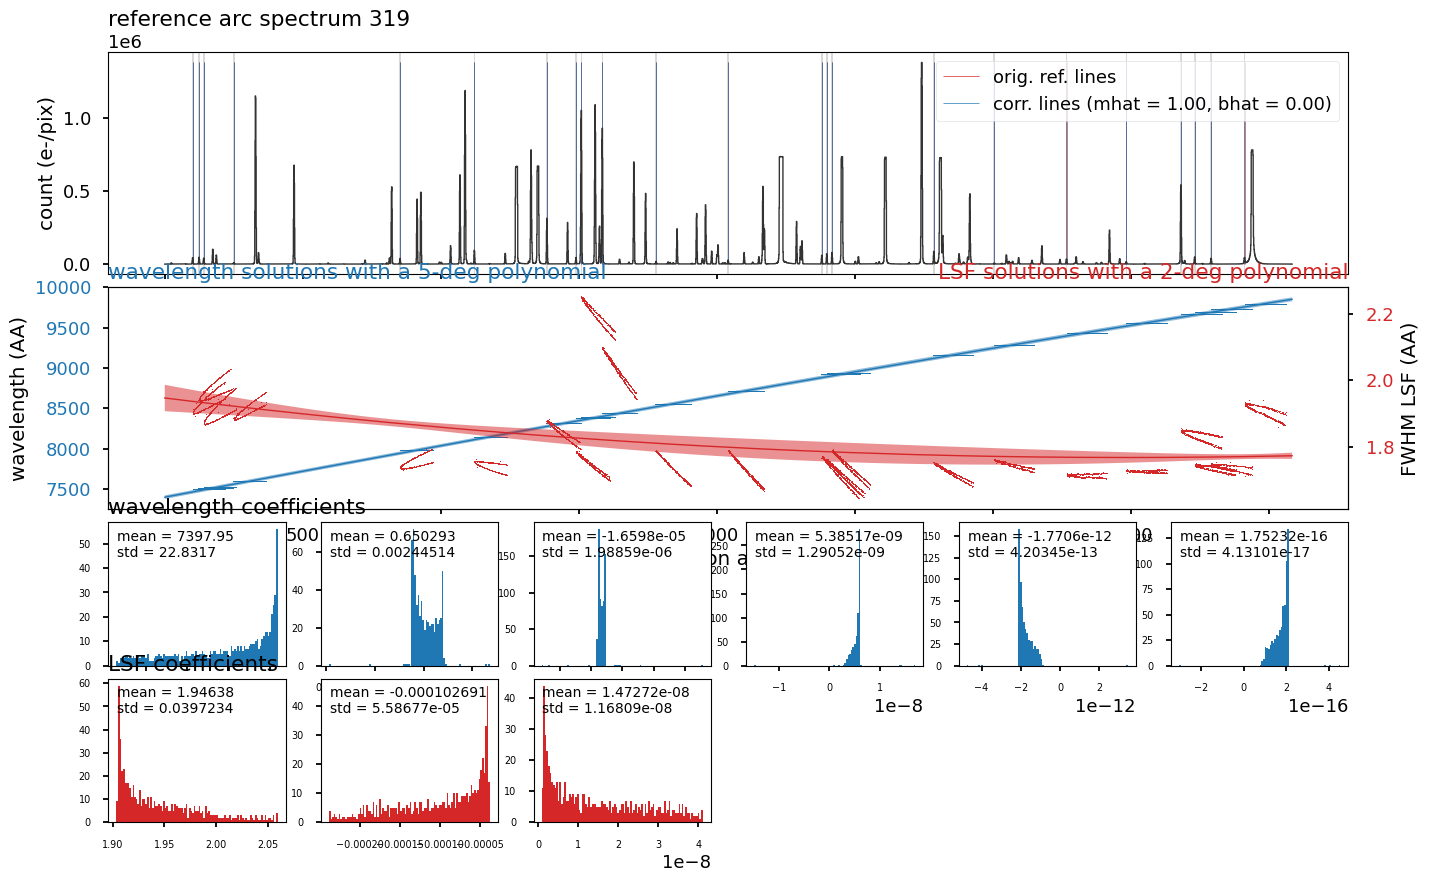

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-z2.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-z2.fits'
[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z3.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_z3.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 35 percentage masked  37.1429 %
[INFO]: 22 good lines found
[INFO]: running cross matching on all 35 identified lines


combined lamps:  /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-z3.fits


[INFO]: max CC = 0.23 for strech = 1.00 and shift = 0.00
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]
measuring arc lines upwards from ref_fiber = 319:   8%|8         | 26/319 [00:00<00:03, 83.08fiber/s][WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)
measuring arc lines upwards from ref_fiber = 319: 100%|##########| 319/319 [00:05<00:00, 63.26fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##########| 328/328 [00:04<00:00, 66.97fiber/s]


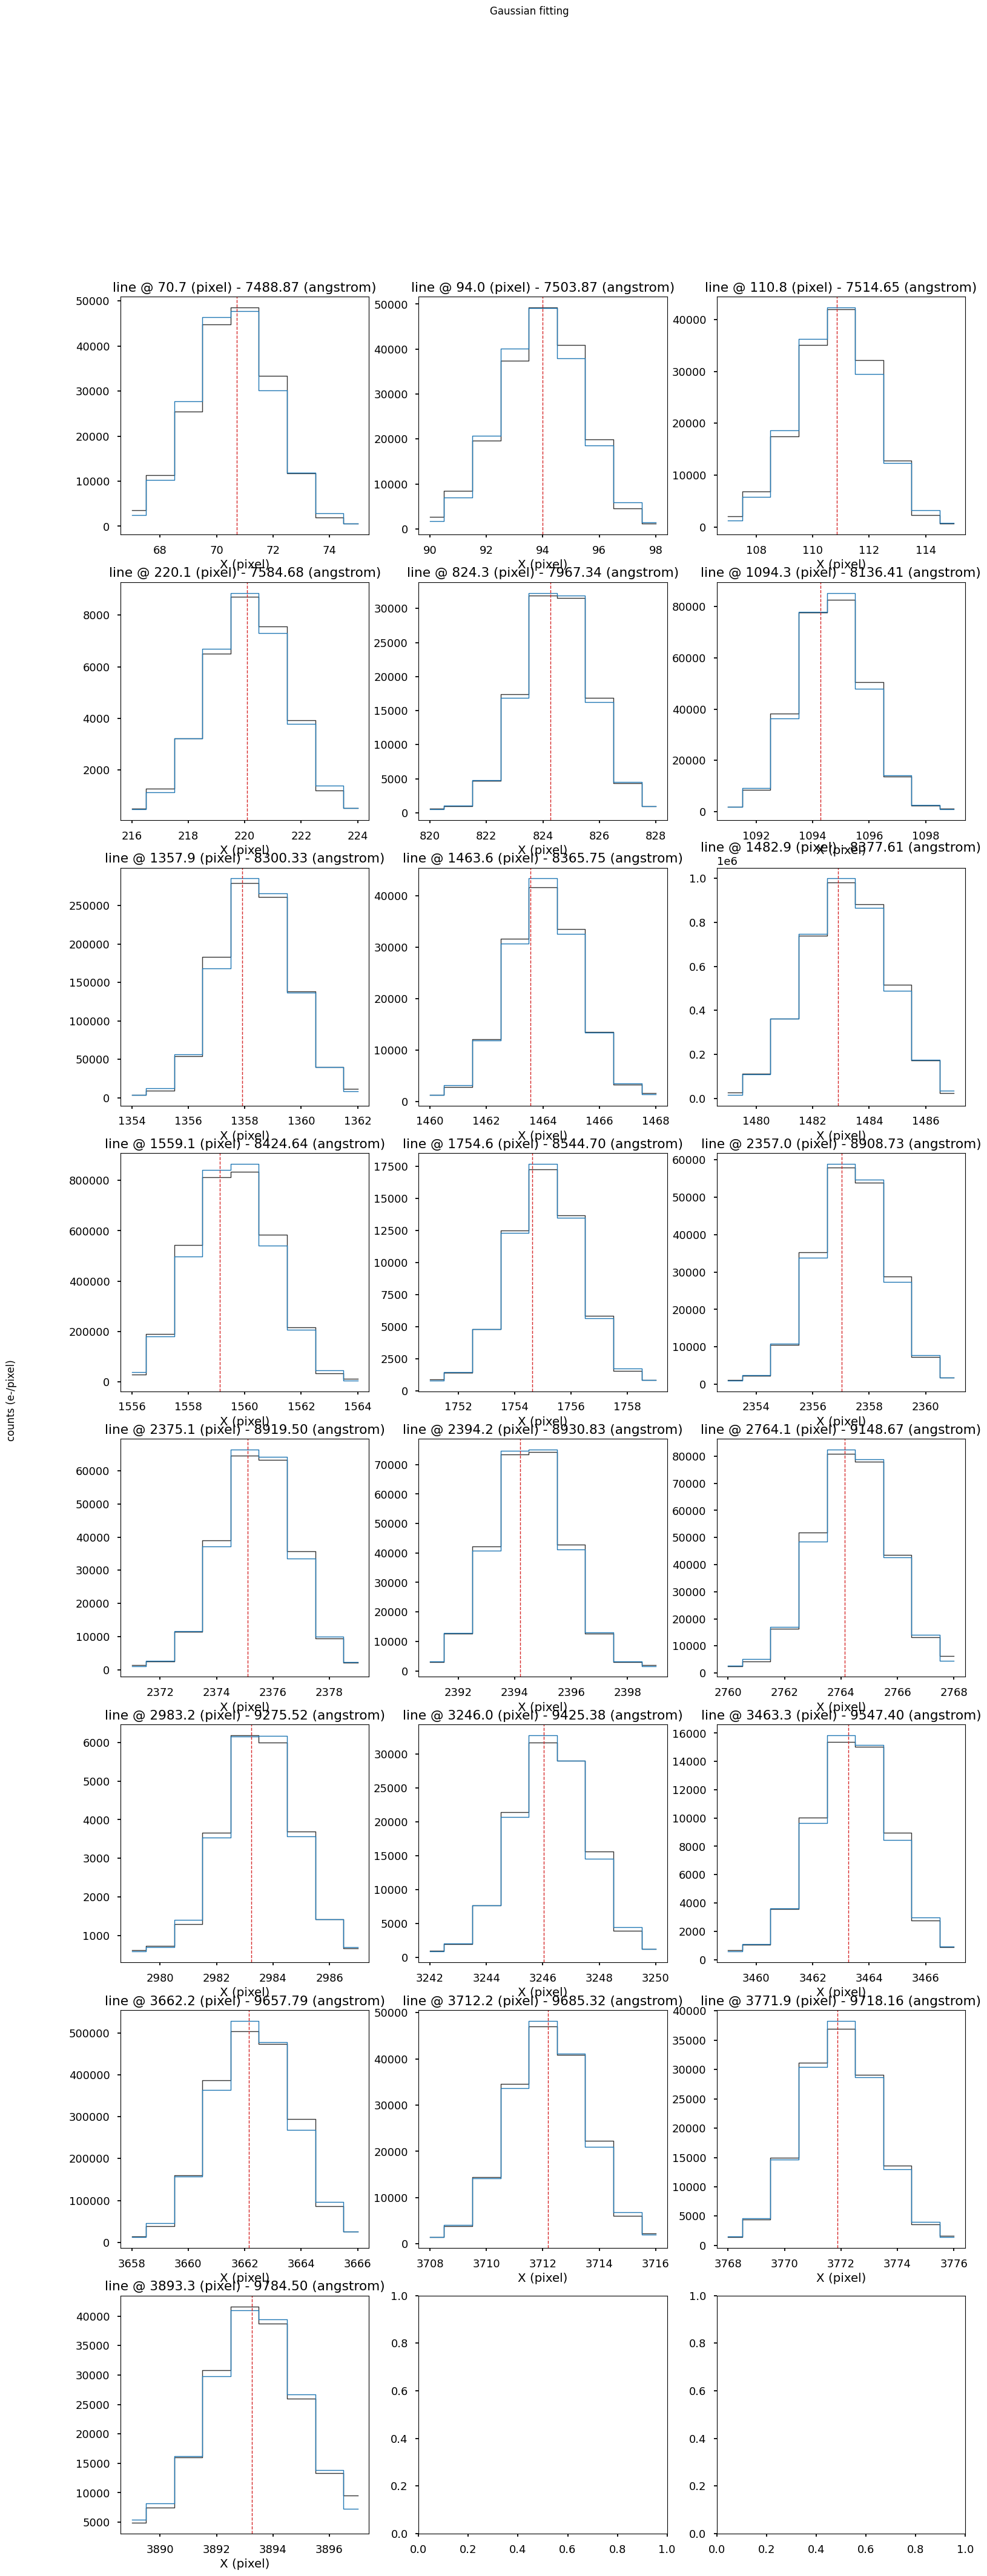

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 51 has all lines masked
[WARNING]: fiber 129 has all lines masked
[WARNING]: fiber 281 has all lines masked
[WARNING]: fiber 443 has all lines masked
[WARNING]: fiber 447 has all lines masked
[WARNING]: fiber 506 has all lines masked
[WARNING]: fiber 512 has all lines masked
[WARNING]: fiber 556 has all lines masked
[WARNING]: fiber 563 has all lines masked
[WARNING]: fiber 575 has all lines masked
[WARNING]: fiber 580 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 0.0283021 AA (0.0476531 pix)
[INFO]: fitting LSF solutions using 2-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.109767 AA (0.180895 pix)


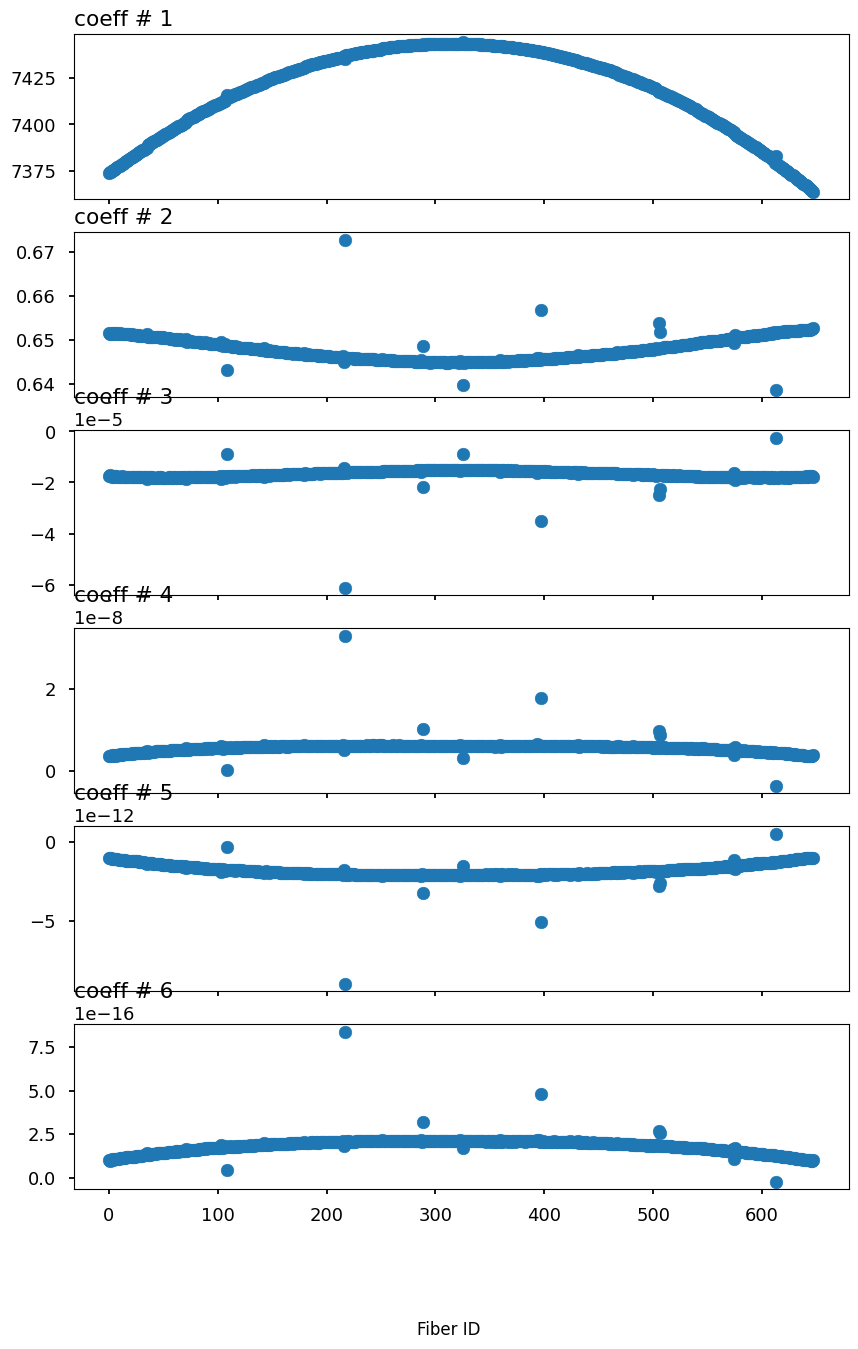

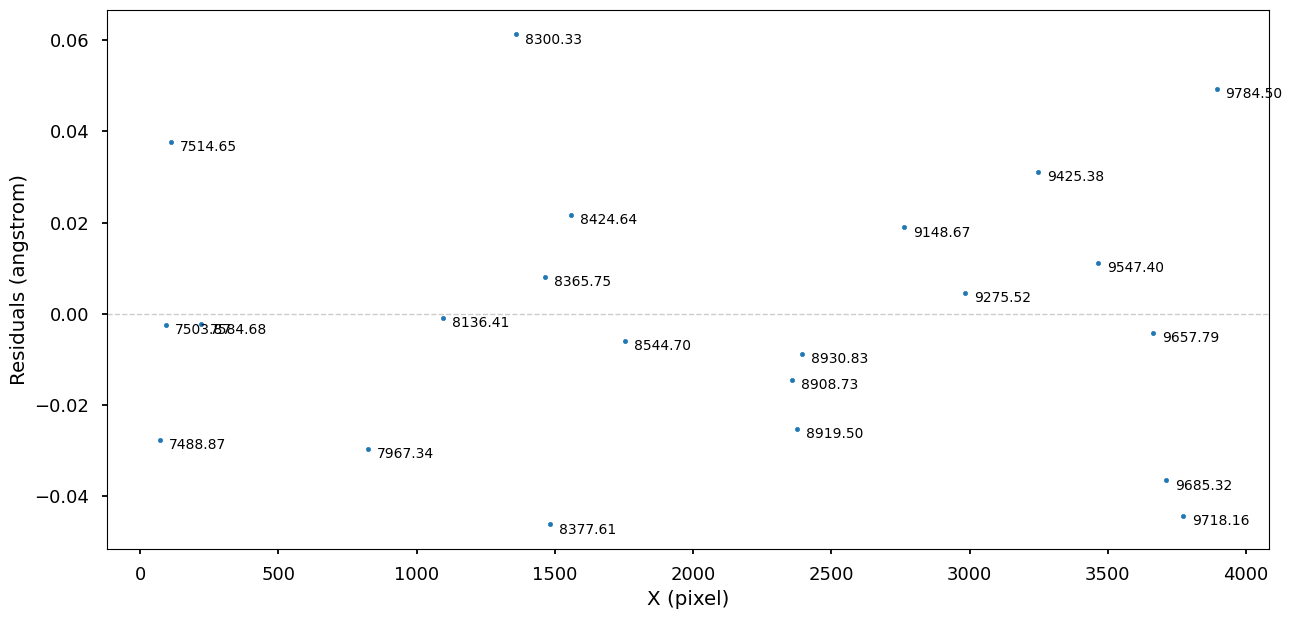

[WARNING]: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations. (UserWarning)


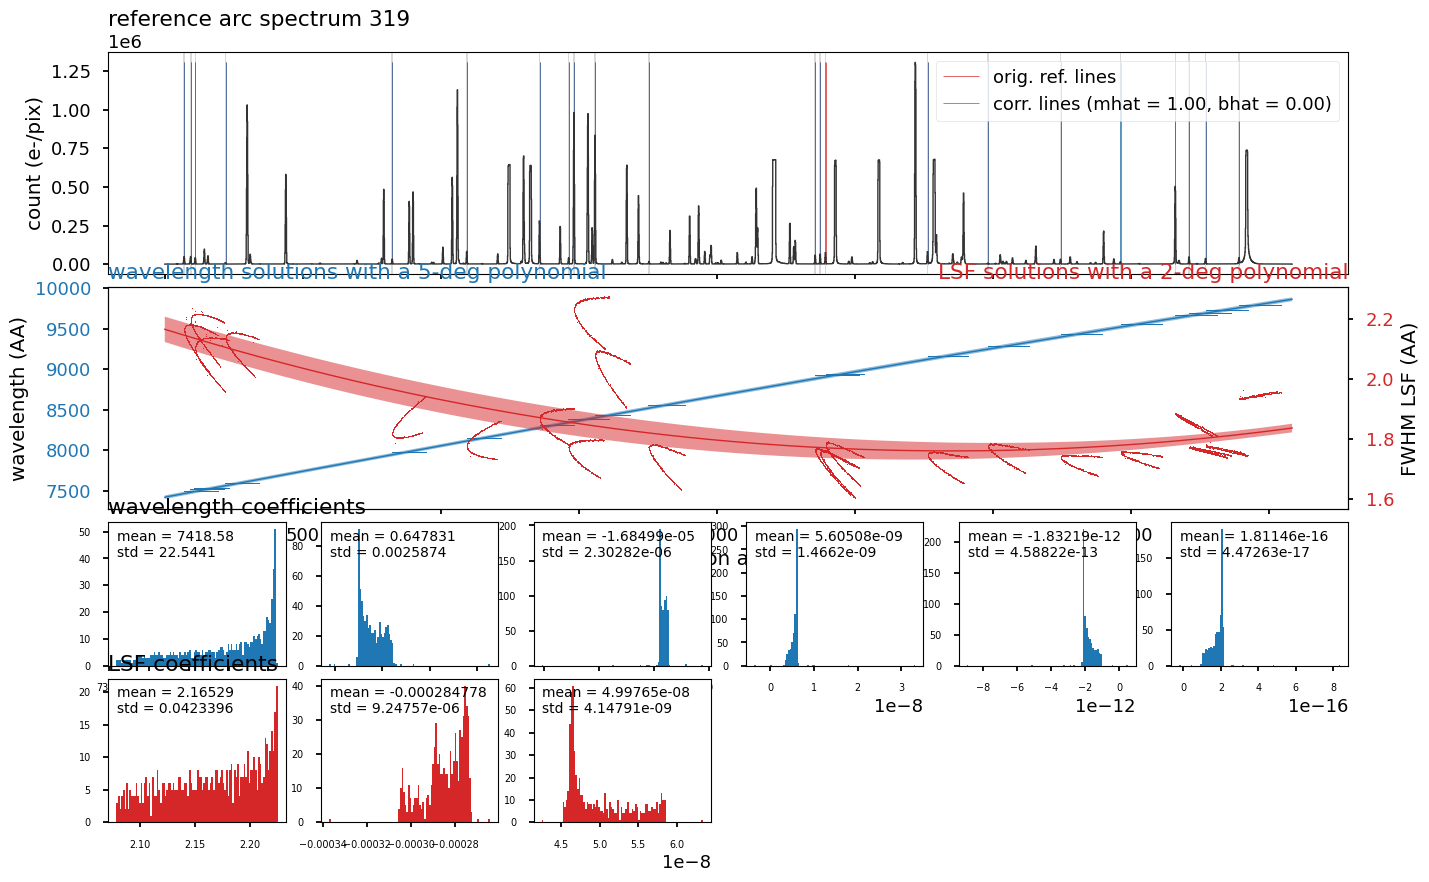

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-z3.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-z3.fits'


In [4]:
ref_fibers = {"r2": 319, "r1": 319, "r3": 319, "z1": 319, "z2": 319, "z3": 319, "b3": 319, "b2": 319, "b1": 319}
lamp_combs = [tuple(lamp.lower() for lamp in ARC_LAMPS)]
arc_analogs = frames_table.query("imagetyp=='arc'").groupby(["camera"])

tileid = frames_table.tileid.iloc[0]

wmarc_paths = []
mwave_paths, mlsf_paths = [], []
for combs in lamp_combs:
    lamps_label = "_".join(combs)
    for camera in arc_analogs.groups:
        # if camera != "z3": continue

        # define input/output paths
        warc_i_path = ",".join([path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"wmarc_{lamp}", camera=camera) for lamp in combs])
        warc_path = path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"wmarc_{lamps_label}", camera=camera)
        harc_path = path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"hmarc_{lamps_label}", camera=camera)
        wmarc_paths.append(warc_path)
        
        # combine RSS files
        rssMethod.combineRSS_drp(in_rsss=warc_i_path, out_rss=warc_path, method="sum")
        
        # subtract continuum from each fiber
        # subtract_continuum(in_rss=warc_path, out_rss=warc_path, median_box=60, thresh=1.001, niter=1)
        
        # fix metadata and additional extensions
        rss_c = rssMethod.loadRSS(warc_path)
        rss_c.setSlitmap(Table(drp.fibermap.data))
        for lamp in combs:
            rss_c._header[lamp.upper()] = "ON"
        rss_c._header["OBJECT"] = ", ".join([lamp.capitalize() for lamp in combs])
        rss_c.writeFitsData(warc_path)
        print("combined lamps: ", warc_path)
        
        mwave_path = os.path.join(masters_path, f"lvm-mwave_{lamps_label}-{camera}.fits")
        mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{lamps_label}-{camera}.fits")
        mwave_paths.append(mwave_path)
        mlsf_paths.append(mlsf_path)

        # NOTE: 8136, 8424

        # determine wavelength solutions
        rssMethod.determine_wavelength_solution(in_arcs=warc_path, out_wave=mwave_path, out_lsf=mlsf_path, ref_fiber=ref_fibers.get(camera, 319), aperture=8,
                                                cc_correction=True, cc_max_shift=50,
                                                poly_disp=5, poly_fwhm=2, poly_cros=2, flux_min=1e-12, fwhm_max=5, rel_flux_limits=[0.001, 1e12], display_plots=True)

        # create pixel table
        rssMethod.create_pixel_table(in_rss=warc_path, out_rss=harc_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)
        # resample
        iwave, fwave = SPEC_CHANNELS[camera[0]]
        rssMethod.resample_wavelength(in_rss=harc_path, out_rss=harc_path, method="linear", disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=10, parallel=0, extrapolate=False)

# new_masters = md.extract_metadata(frames_paths=wmarc_paths)
# md.add_masters(new_masters)